In [2]:
# Data preprocessing
import pandas as pd
import numpy as np
 
# Hide SettingWithCopy warning (delete this code if you aren't sure what it does)
pd.options.mode.chained_assignment = None
 
# Plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sns
import scikitplot as skplt
 
# Machine learning
from sklearn import metrics
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

from collections import Counter
from mplsoccer import Pitch, VerticalPitch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


## Cleaning The Data

Let us pull up the data that we created in the first notebook. At first, we will remove unnecessary columns from our dataset. The removed columns are: firstName, lastName, label, venue, date, eventSec. 

In [3]:
shots_model = pd.read_csv("C:/Users/oishi/Downloads/Soccermetrics/shots_matrix.csv")
shots_model=shots_model.drop(columns=['Unnamed: 0',  'firstName',  'lastName',  'label', 'venue', 'date', 'eventSec'])

In [4]:
shots_model

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,...,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,matchPeriod
0,0,9,29,1,0,1,0,0,0,21.0,...,0,1,0,0,0,1,0,0,0,1H
1,0,29,29,1,0,1,0,0,1,21.0,...,0,1,0,0,0,1,0,0,0,1H
2,0,4,57,0,0,1,0,0,1,7.0,...,1,0,0,0,0,0,0,0,1,1H
3,0,4,61,0,0,0,1,0,0,11.0,...,0,0,0,0,0,0,0,0,1,1H
4,0,25,33,1,1,0,0,0,1,17.0,...,1,0,0,0,0,1,0,0,0,1H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45279,0,5,45,1,1,0,0,0,1,5.0,...,1,0,0,0,1,0,0,0,0,2H
45280,0,7,38,1,1,0,0,0,1,12.0,...,1,0,0,0,0,0,1,0,0,2H
45281,1,10,46,1,1,0,0,0,1,4.0,...,1,0,0,0,0,0,0,0,1,2H
45282,0,21,32,1,0,1,0,0,1,18.0,...,0,1,0,0,0,1,0,0,0,2H


In [5]:
shots_model.columns

Index(['Goal', 'X', 'Y', 'side_of_field', 'left_foot', 'right_foot', 'header',
       'counter_attack', 'strong_foot', 'C', 'Distance', 'Angle',
       'out_swinging', 'in_swinging', 'rebound', 'prev_cross', 'prev_touch',
       'prev_pass', 'prev_smart_pass', 'free_kick', 'prev_duel',
       'matchPeriod'],
      dtype='object')

Since our goal is to predict whether a shot ended up in goal, "Goal" is our target variable in this dataset. Let us see the distribution of the target variable.

Text(0, 0.5, 'Count')

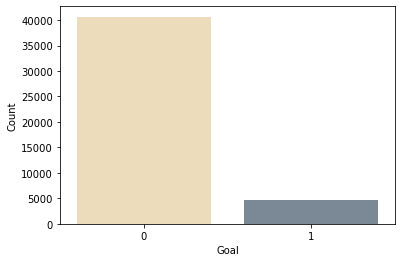

In [6]:
b = sns.countplot(x='Goal', data=shots_model, palette=['wheat', 'lightslategrey'])
b.set_xlabel("Goal", fontsize=10)
b.set_ylabel("Count", fontsize=10)

Looking at the information above, we can see that under 12.5% of the shots in the data resulted in a goal, i.e the data is imbalanced!

#### Checking for missing values:

In [7]:
# count missing values
print(shots_model.isnull().sum())

Goal               0
X                  0
Y                  0
side_of_field      0
left_foot          0
right_foot         0
header             0
counter_attack     0
strong_foot        0
C                  0
Distance           0
Angle              0
out_swinging       0
in_swinging        0
rebound            0
prev_cross         0
prev_touch         0
prev_pass          0
prev_smart_pass    0
free_kick          0
prev_duel          0
matchPeriod        0
dtype: int64


We can see that there are no missing values in the dataset, so we do not need to perform any imputation.

<AxesSubplot:xlabel='Distance'>

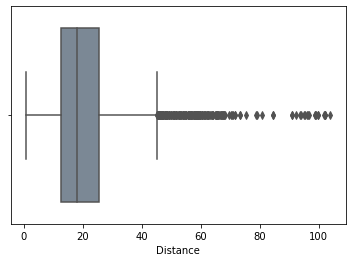

In [8]:
sns.boxplot(x=shots_model['Distance'], color = 'lightslategrey')

In [9]:
# compute IQR
Q1 = shots_model['Distance'].quantile(0.25)
Q3 = shots_model['Distance'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers using IQR
outliers = (shots_model['Distance'] < Q1 - 1.5*IQR) | (shots_model['Distance'] > Q3 + 1.5*IQR)
print(outliers.sum())

204


In [10]:
# remove outliers
shots_model = shots_model[~outliers]

In [11]:
shots_model

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,...,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,matchPeriod
0,0,9,29,1,0,1,0,0,0,21.0,...,0,1,0,0,0,1,0,0,0,1H
1,0,29,29,1,0,1,0,0,1,21.0,...,0,1,0,0,0,1,0,0,0,1H
2,0,4,57,0,0,1,0,0,1,7.0,...,1,0,0,0,0,0,0,0,1,1H
3,0,4,61,0,0,0,1,0,0,11.0,...,0,0,0,0,0,0,0,0,1,1H
4,0,25,33,1,1,0,0,0,1,17.0,...,1,0,0,0,0,1,0,0,0,1H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45279,0,5,45,1,1,0,0,0,1,5.0,...,1,0,0,0,1,0,0,0,0,2H
45280,0,7,38,1,1,0,0,0,1,12.0,...,1,0,0,0,0,0,1,0,0,2H
45281,1,10,46,1,1,0,0,0,1,4.0,...,1,0,0,0,0,0,0,0,1,2H
45282,0,21,32,1,0,1,0,0,1,18.0,...,0,1,0,0,0,1,0,0,0,2H


We have identified 206 outliers in the "charges" column using the IQR method and removed them from the dataset.

## Exploratory Data Analysis

Let us firtst take a look at the distribution of shots by distance and angle.

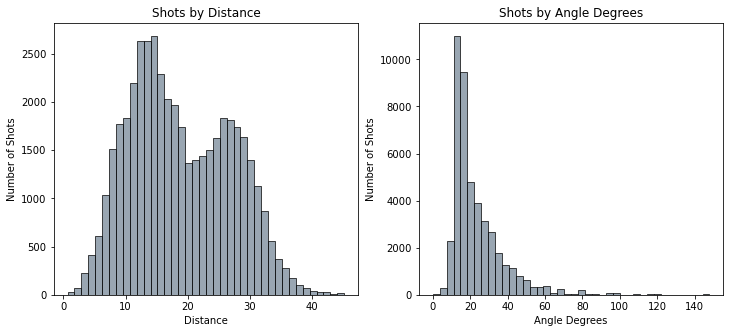

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(shots_model, x='Distance', bins=40, kde=False, ax=axes[0], color = 'lightslategrey')
sns.histplot(shots_model, x='Angle', bins=40, kde=False, ax=axes[1], color = 'lightslategrey')

axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Number of Shots')
axes[0].set_title('Shots by Distance')

axes[1].set_xlabel('Angle Degrees')
axes[1].set_ylabel('Number of Shots')
axes[1].set_title('Shots by Angle Degrees')

plt.show()

There are few takeawys we can get from the above distributions: 
1. Most shots occur between 10 and 20 meters.
2. Shots within 6 meters are less common than those beyond 10 meters.
3. Interestingly, there is a dip in the frequency of shots taken from 18 to 25 meters.
4. Players usually take shots from a central position close to the goal, rather than from an angle.


The distributions show that it's hard to score a goal from a position that is very close to the goal and in the center. They do not show how successful the shots were, only where they were taken from. 

Next, we will look into the shots which resulted in a goal and shots which didn't.

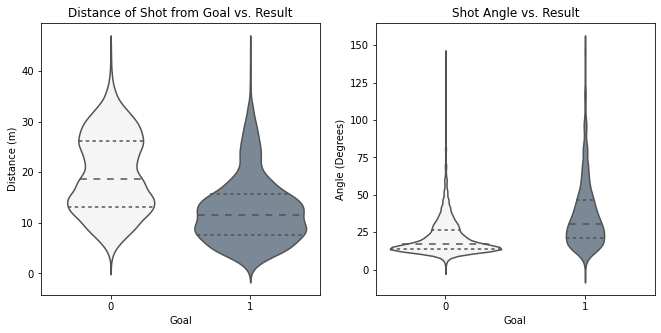

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

colors = {0: 'whitesmoke', 1: 'lightslategrey'}
palette = sns.color_palette([colors[x] for x in colors])


# violin plot for distance
sns.violinplot(x='Goal', y='Distance', data=shots_model, inner='quartile', ax=axes[0], palette=palette)
axes[0].set_xlabel('Goal')
axes[0].set_ylabel('Distance (m)')
axes[0].set_title('Distance of Shot from Goal vs. Result')

# violin plot for angle
sns.violinplot(x='Goal', y='Angle', data=shots_model, inner='quartile', ax=axes[1], palette=palette)
axes[1].set_xlabel('Goal')
axes[1].set_ylabel('Angle (Degrees)')
axes[1].set_title('Shot Angle vs. Result')

plt.show()

We have used a violin plot here, which is similar to a box and whiskers plot. The plot shows the distribution of shot distances and angles in a game, split up by whether or not the shot resulted in a goal. The plot also includes a smoothed estimate of the distribution, called a kernel density estimate.

By looking at the plot, the we can easily say that shots resulting in goals tend to be taken from much closer to the goal than shots that do not result in goals. The mean for shots that resulted in a goal were taken from a distance of about 12 meters, while shots that did not result in a goal were taken from about 18 meters away.

Additionally, the plot shows that goals are typically scored from angles of 15 degrees to about 50 degrees. This means that shots taken from the center or near the goal tend to be more successful.

Now, we will take a look into how headers impact the mean and the distribution. 

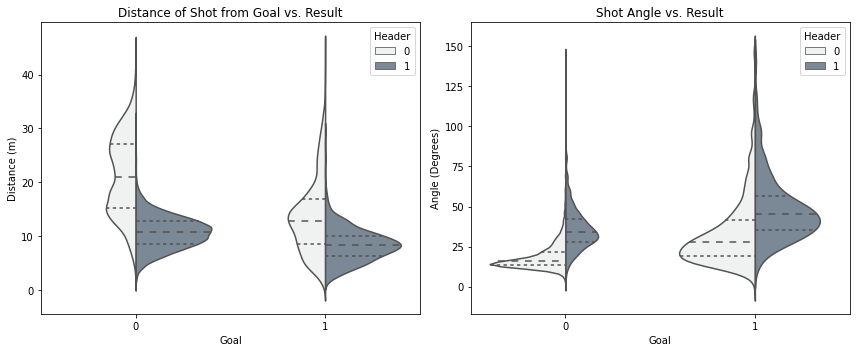

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# violin plot for distance
sns.violinplot(x='Goal', y='Distance', hue='header', data=shots_model, inner='quartile', split=True, ax=axes[0], color = 'lightslategrey')
axes[0].set_xlabel('Goal')
axes[0].set_ylabel('Distance (m)')
axes[0].set_title('Distance of Shot from Goal vs. Result')
axes[0].legend(title='Header', loc='upper right')

# violin plot for angle
sns.violinplot(x='Goal', y='Angle', hue='header', data=shots_model, inner='quartile', split=True, ax=axes[1],  color = 'lightslategrey')
axes[1].set_xlabel('Goal')
axes[1].set_ylabel('Angle (Degrees)')
axes[1].set_title('Shot Angle vs. Result')
axes[1].legend(title='Header', loc='upper right')

plt.tight_layout()
plt.show()

We plot a similar violin plot for shots which are made with the head and shots which are not. The headers are typically taken from within the 18-yard box, which is about 16.5 meters away from the goal.

The means and distributions of the results (whether the header resulted in a goal or not) do not differ by much. So we can say that the success rate of headers is not strongly influenced by the exact distance from which the header is taken, at least based on the data analyzed so far.

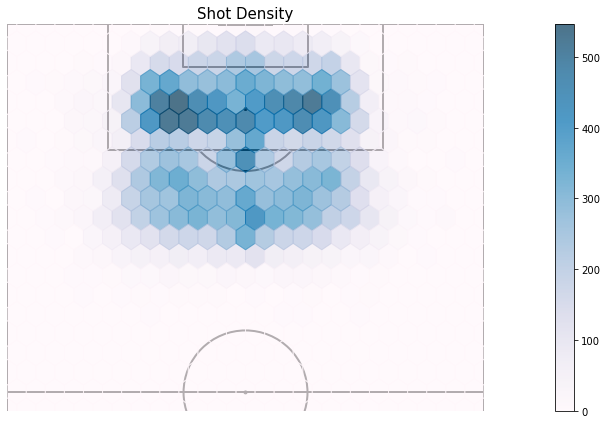

In [15]:
# create pitch
pitch = VerticalPitch(half=True, pitch_type='opta', line_color='black', linewidth=2)

# create figure
fig, ax = pitch.draw(figsize=(20, 6))

df_shots = shots_model[shots_model['header']==0]

plt.hexbin(data =df_shots, x='Y', y='X',zorder=1,cmap='PuBu',gridsize=(25,10),alpha=.7,extent=(0,100,0,52.5))
ax.set_xlim(0, 100)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Shot Density', fontsize = 15)


# show plot
plt.show()

The density plots are similar to the violin plots in that they provide information about where shots are taken and goals are scored on the pitch. However, density plots give us an even clearer visual understanding of this by showing us how both distance and angle impact the distribution of shots on the same plot.

The violin plots showed us that shots are rarely taken from the sides of the box due to the poor angle. Instead, the majority of shots are taken around the penalty spot, which is located 11 meters away from the goal. And, as the density plots show, this is where the highest concentration of shots are taken from.

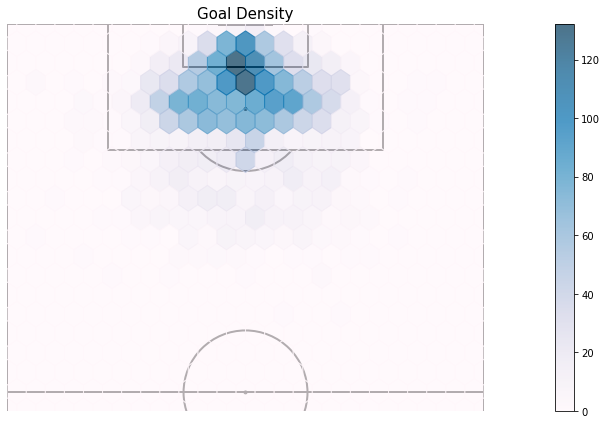

In [16]:
# create pitch
pitch = VerticalPitch(half=True, pitch_type='opta', line_color='black', linewidth=2)

# create figure
fig, ax = pitch.draw(figsize=(20, 6))

df_goals = shots_model[(shots_model['Goal']==1) & (shots_model['header']==0)]

plt.hexbin(data =df_goals, x='Y', y='X',zorder=1,cmap='PuBu',gridsize=(25,10),alpha=.7,extent=(0,100,0,52.5))
ax.set_xlim(0, 100)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Goal Density', fontsize = 15)


# show plot
plt.show()

Additionally, the density plots confirm that goals are typically scored within a narrow passage within 11 meters of the goal. By looking at the density of goals scored on the plot, we can see that this area is the most heavily concentrated with successful shots.

In summary, the density plots provide us with a more detailed and accurate understanding of where shots and goals are most likely to occur on the pitch, and how distance and angle impact these distributions.



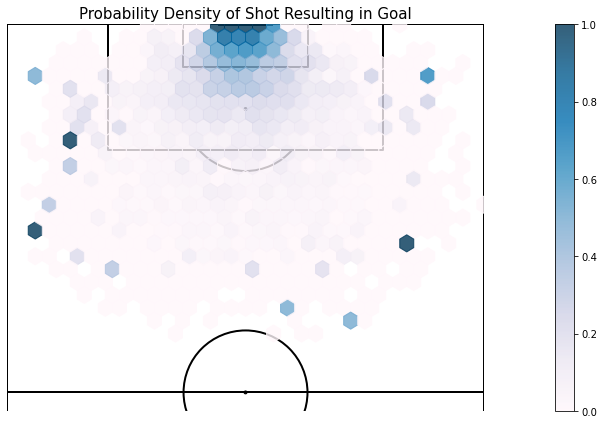

In [17]:
# create pitch
pitch = VerticalPitch(half=True, pitch_type='opta', line_color='black', linewidth=2)

# create figure
fig, ax = pitch.draw(figsize=(20, 6))

#probabilty density of shot resulting in goals
df_shots =shots_model[shots_model['header']==0]
prob=np.array(df_shots['Goal'])

plt.hexbin(data = df_shots,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='PuBu',gridsize=(34,15),
           alpha=.8, extent=(0,100,0,52.5))
ax.set_xlim(0, 100)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Shot Resulting in Goal', fontsize = 15)


# show plot
plt.show()

Now we take a loot at a density plot showing the probability of a shot resulting in a goal, based on the distance from the goal at which the shot is taken. The density plot shows that as the distance from the goal increases, the probability of a shot resulting in a goal decreases. This is not surprising, as it is generally easier to score from closer range.

However, there are some outliers in which the probability density in certain distance bins is very high. This means that despite the generally lower probability of scoring from those distances, there were a few shots taken from those areas that did result in goals. 

One interesting finding of this plot is that the probability of scoring from beyond 11 meters out is actually lower than many people might expect. This is important because it suggests that shots taken from outside the box are often less effective than we might think. In fact, the plot suggests that shots from outside the box are quite difficult and inefficient, and are therefore less likely to result in a goal.

Now, let's take a look at the headers.


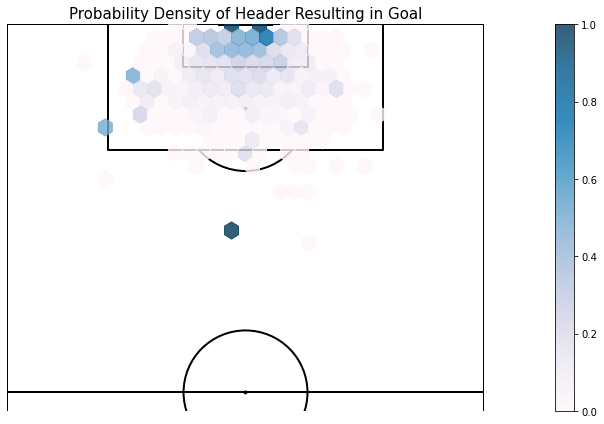

In [18]:
# create pitch
pitch = VerticalPitch(half=True, pitch_type='opta', line_color='black', linewidth=2)

# create figure
fig, ax = pitch.draw(figsize=(20, 6))

#probabilty density of shot resulting in goals
df_header =shots_model[shots_model['header']==1]
prob=np.array(df_header['Goal'])

plt.hexbin(data = df_header,x='Y', y='X',C=prob,reduce_C_function=np.mean,cmap='PuBu',gridsize=(34,15),
           alpha=.8, extent=(0,100,0,52.5))
ax.set_xlim(0, 100)
ax.set_ylim(52.5,0)
plt.colorbar()
plt.axis('off')
ax.set_title('Probability Density of Header Resulting in Goal', fontsize = 15)


# show plot
plt.show()

Headers exhibit a similar trend to regular shots, in that the probability of scoring a goal decreases as the distance from the goal increases. However, the probability values for headers are generally lower than those for regular shots.

While headers are more likely to occur closer to the goal, they are also a more difficult chance to put away. This could be due to a number of factors, such as the fact that headers require more precision and control than regular shots, or that they are more difficult to execute while under pressure from defenders.

The fact that headers are generally more difficult to convert into goals than regular shots is an important discovery. It means that when evaluating a player's performance, we need to take into account not just the number of headers attempted, but also the quality of those chances. In other words, a player who attempts a lot of headers but has a low conversion rate may not be as effective in front of goal as a player who attempts fewer headers but has a higher conversion rate.

Overall, this analysis helps to provide a more nuanced understanding of the different types of chances that occur in a football match, and can help us to more accurately evaluate a player's performance and the quality of their chances.

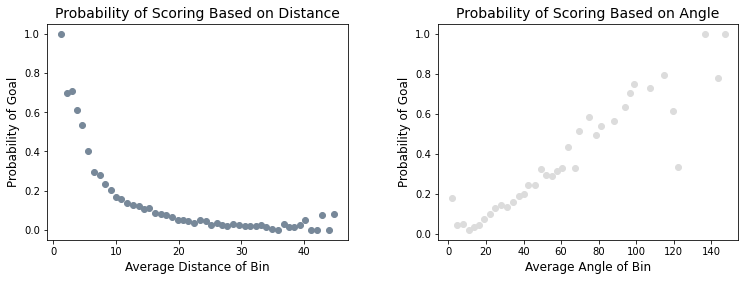

In [19]:
# Bin the data by distance and calculate mean probability of goal for each bin
bins = pd.cut(shots_model['Distance'], bins=50)
dist_prob = shots_model.groupby(bins)['Goal'].mean()
dist_mean = shots_model.groupby(bins)['Distance'].mean()

# Scatter plot of probability of goal vs average distance of bin
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(dist_mean, dist_prob, color='lightslategrey')
axes[0].set_xlabel('Average Distance of Bin', fontsize=12)
axes[0].set_ylabel('Probability of Goal', fontsize=12)
axes[0].set_title('Probability of Scoring Based on Distance', fontsize=14)

# Bin the data by angle and calculate mean probability of goal for each bin
bins = pd.cut(shots_model['Angle'], bins=50)
angle_prob = shots_model.groupby(bins)['Goal'].mean()
angle_mean = shots_model.groupby(bins)['Angle'].mean()

# Scatter plot of probability of goal vs average angle of bin
axes[1].scatter(angle_mean, angle_prob, color='gainsboro')
axes[1].set_xlabel('Average Angle of Bin', fontsize=12)
axes[1].set_ylabel('Probability of Goal', fontsize=12)
axes[1].set_title('Probability of Scoring Based on Angle', fontsize=14)


# Adjust spacing between subplots and the edge of the figure
fig.subplots_adjust(wspace=0.3, left=0.1, right=0.9, bottom=0.2, top=0.8)

# Show plot
plt.show()

One intriguing observation that stands out is the exponential decrease in the probability of scoring as shots are taken further away from the goal. This is significant because it suggests that shots taken from a distance have much lower value. Why is this the case? Until now, we have overlooked the fact that the angle of the goal decreases as we move away from it, leading to a "doubling factor" for distance. 

A possible explanation for this phenomenon is that as the distance between the shooter and the goal increases, the shot has to travel a longer distance, making it harder to score. Additionally, the goal becomes smaller, making it even more challenging to hit the target accurately.

### Feature Engineering and Correlation

In [20]:
# Create the LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the categorical columns
le.fit(shots_model['matchPeriod'])


# Transform the 'matchPeriod' column into numerical values
shots_model['matchPeriod'] = le.transform(shots_model['matchPeriod'])

We will use correlation plots to visualize the correlations between different variables in our dataset. Correlation is a statistical measure that indicates the extent to which two or more variables are related. A correlation plot displays these correlations in a visual form, making it easier to identify patterns and relationships between variables.


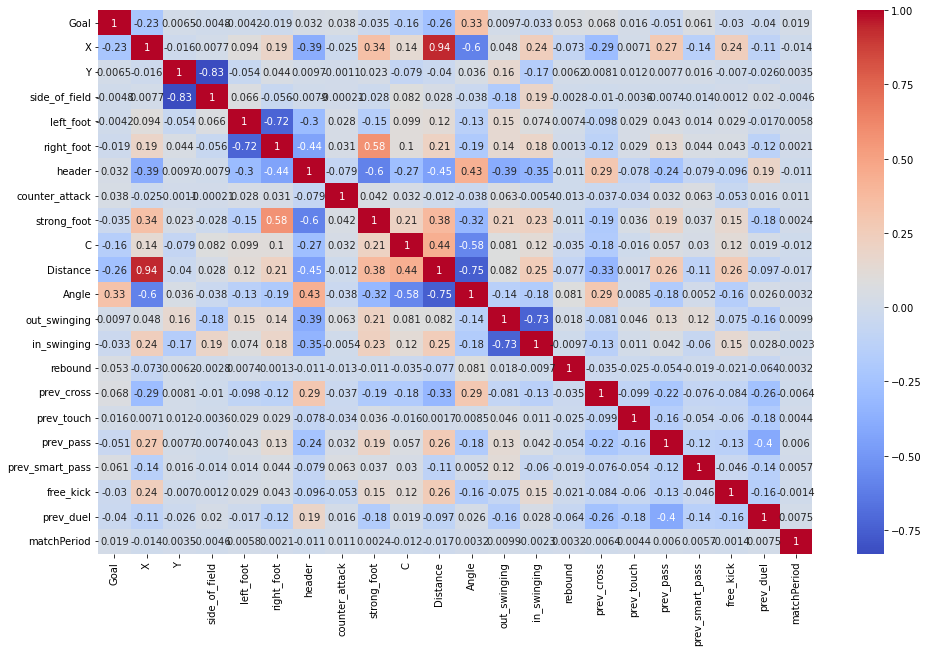

In [21]:
# Compute correlation matrix
corr_matrix = shots_model.corr()

# set figure size
plt.figure(figsize=(16, 10))

# Visualize correlation matrix with a heatmap
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

# show plot
plt.show()

After examining the heatmap, we can observe a strong linear relationship among X, Y, Distance, and the side of the field. However, highly correlated variables may not provide unique insights into the outcome of interest. 

To gain a better understanding of the impact of other factors on Goal, it may be necessary to eliminate the influence of X, Y, and the side of the field. One way to achieve this is by removing these variables from the dataset and analyzing the correlation between obesity and the remaining variables. By doing so, we can investigate the association between Goal and other factors, independent of X, Y, and the side of the field. This approach could offer a more comprehensive understanding of the variables that impact the outcome of interest.

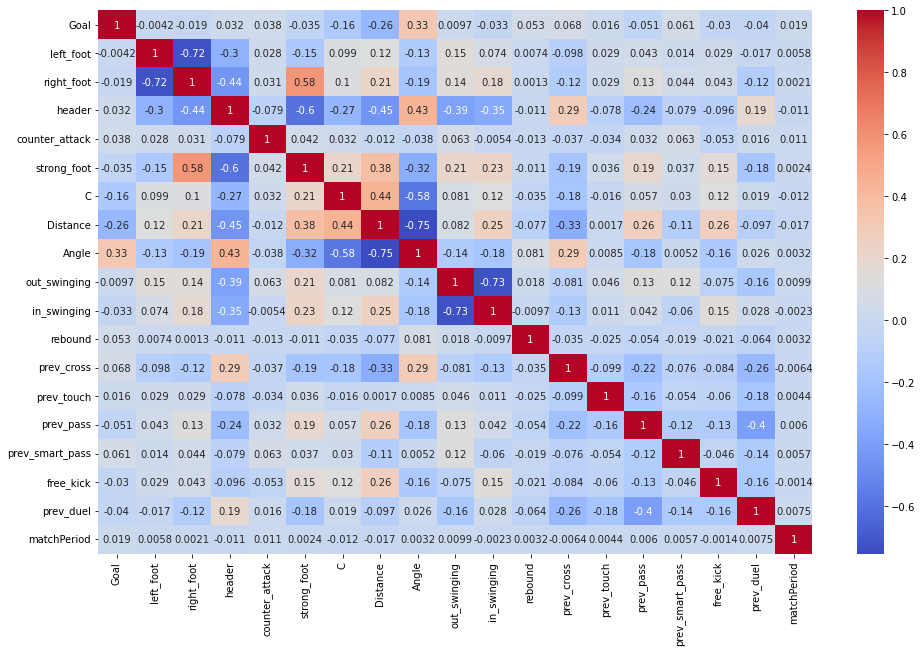

In [22]:
newData = shots_model.drop(['X', 'Y', 'side_of_field'], axis=1)

# set figure size
plt.figure(figsize=(16, 10))

# Visualize correlation matrix with a heatmap
sns.heatmap(newData.corr(), cmap="coolwarm", annot=True)

# show plot
plt.show()


In [23]:
newData

,Goal,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,matchPeriod
0,0,0,1,0,0,0,21.0,17.123694,13.885382,0,1,0,0,0,1,0,0,0,0
1,0,0,1,0,0,1,21.0,33.632141,11.277838,0,1,0,0,0,1,0,0,0,0
2,0,0,1,0,0,1,7.0,6.348039,48.813019,1,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,11.0,8.578485,27.055300,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,17.0,28.682679,13.356273,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45279,0,1,0,0,0,1,5.0,6.254798,56.199735,1,0,0,0,1,0,0,0,0,1
45280,0,1,0,0,0,1,12.0,10.982172,26.648679,1,0,0,0,0,0,1,0,0,1
45281,1,1,0,0,0,1,4.0,10.846585,36.399362,1,0,0,0,0,0,0,0,1,1
45282,0,0,1,0,0,1,18.0,25.219439,14.533147,0,1,0,0,0,1,0,0,0,1


### Normalization

In [24]:
# Select the columns to normalize
cols_to_normalize = ['left_foot', 'right_foot', 'header', 'counter_attack', 'strong_foot', "C",
                "Distance", 'Angle', 'out_swinging', 'in_swinging', 'rebound', 'prev_cross', 'prev_touch',
       'prev_pass', 'prev_smart_pass', 'free_kick', 'prev_duel', 'matchPeriod']

# Create a copy of the dataframe to work with
normalized_df = newData.copy()

# Normalize the selected columns
normalized_df[cols_to_normalize] = (shots_model[cols_to_normalize] - shots_model[cols_to_normalize].min()) / \
                                   (shots_model[cols_to_normalize].max() - shots_model[cols_to_normalize].min())


# Preview the resulting DataFrame
normalized_df.head()

,Goal,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,matchPeriod
0,0,0.0,1.0,0.0,0.0,0.0,0.428571,0.369688,0.093830,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,1.0,0.0,0.0,1.0,0.428571,0.740831,0.076209,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,1.0,0.142857,0.127429,0.329851,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0.0,0.0,1.0,0.0,0.0,0.224490,0.177574,0.182824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1.0,0.0,0.0,0.0,1.0,0.346939,0.629557,0.090254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Let's start with some Machine Learning!

### Choosing our modeling approach

At first glance, it may seem that predicting the probability of a goal from a shot is a regression problem, as the output values can range from 0 to 1. However, I believe it is more effective to treat this as a classification problem and train the model to classify each shot as either resulting in a goal or not. We can then use the probability estimates for each shot's classification to derive the xG values. This approach allows us to more easily interpret and analyze the model's predictions in terms of goal-scoring likelihood, which is the ultimate objective of our analysis.

Below is a list of some common types of classification models:

Linear classifiers: Logistic Regression, Naive Bayes, K-Nearest Neighbours, Support Vector Machines.
Tree-based models: Decision Tree, Random Forest, Gradient Boosting Algorithms.
Neural Networks.

Most of the public xG models are using either Linear or Logistic Regression. We will also take a look at Random Forest, Gradient Boosting and Neural Networks along with Logistic Regression. 

### Fitting Initial Logistic Regression Model

In [25]:
# splitting test and train data
X = normalized_df.drop(columns=['Goal'])
Y = normalized_df['Goal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Create and fit the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, Y_train)

# Make predictions on the testing set
Y_pred = lr.predict(X_test)
Y_pred_prob = lr.predict_proba(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.906832298136646


Accuracy (mean): 0.9022182786157942
Average Precision (mean): 0.3479841899562429
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      8092
           1       0.63      0.11      0.19       924

    accuracy                           0.90      9016
   macro avg       0.77      0.55      0.57      9016
weighted avg       0.88      0.90      0.87      9016



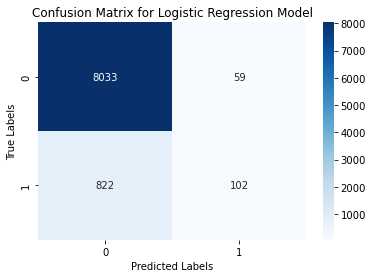

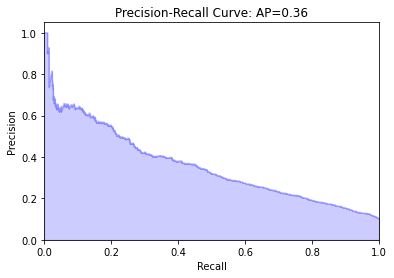

In [26]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for cross-validation
num_splits = 5

# Create the stratified K-Fold object
skf = StratifiedKFold(n_splits=num_splits, random_state=42, shuffle=True)

# Define the dataset
X = normalized_df.drop(columns=['Goal'])
Y = normalized_df['Goal']

# Initialize empty lists for accuracy and average precision
accuracy_list = []
average_precision_list = []

# Loop through each fold and fit the model
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Create and fit the logistic regression model
    lr = LogisticRegression()
    lr.fit(X_train, Y_train)

    # Make predictions on the testing set
    Y_pred = lr.predict(X_test)
    Y_pred_prob = lr.predict_proba(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracy_list.append(accuracy)

    # Get the precision-recall curve
    y_score = lr.decision_function(X_test)
    average_precision = average_precision_score(Y_test, y_score)
    average_precision_list.append(average_precision)
    
# Print the results of the cross-validation
print("Accuracy (mean):", np.mean(accuracy_list))
print("Average Precision (mean):", np.mean(average_precision_list))

# Get the classification report for the last fold
print("Classification Report:\n", classification_report(Y_test, Y_pred))

# Generate confusion matrix for the last fold
cm = confusion_matrix(Y_test, Y_pred)

# Create heatmap of confusion matrix for the last fold
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

# Plot the precision-recall curve for the last fold
precision, recall, _ = precision_recall_curve(Y_test, y_score)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
plt.show()

At first glance, the Accuracy of the model looks surprisingly good at 90%. Let us take a deeper dive into the model and take a look at the Precision, Recall and the Confusion Matrix. 

So, in our case, precision measures the proportion of shots that the model predicted as goals that were actually goals and recall measures the proportion of actual goals that the model correctly identified. 

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      8092
           1       0.63      0.11      0.19       924

    accuracy                           0.90      9016
   macro avg       0.77      0.55      0.57      9016
weighted avg       0.88      0.90      0.87      9016



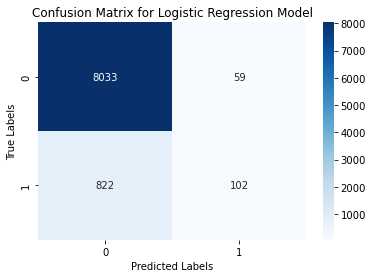

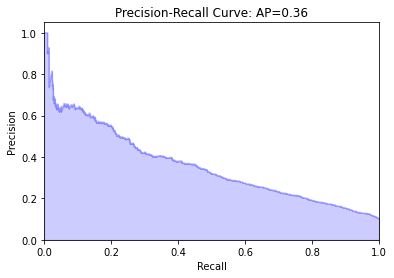

In [27]:
# Get the classification report
print("Classification Report:\n", classification_report(Y_test, Y_pred))

# Get the precision-recall curve
y_score = lr.decision_function(X_test)
average_precision = average_precision_score(Y_test, y_score)
precision, recall, _ = precision_recall_curve(Y_test, y_score)

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
plt.show()

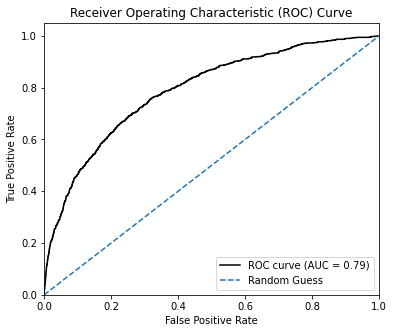

In [28]:
from sklearn.metrics import auc
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='black')
plt.plot([0, 1], [0, 1], '--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Upon closer examination, it becomes apparent that the low precision and recall scores for the positive class can be attributed to the imbalance in the data. 

In an xG model, it is crucial that the model accurately predicts the positive class, which represents the shots resulting in goals. However, in this model, the recall score for identifying actual goals in the dataset was only 10%, which is quite low. Moreover, the model also classified 71% of the shots it predicted properly as goals, which is not ideal.

When we examine the confusion matrix, it becomes evident that the number of false negatives (802) is considerably higher than the number of true positives (94), which is not what we want. As a result, our model is not performing well in identifying the instances of a 'goal', and it's also wrongly predicting 'no goal' more frequently than we desire.


### Dealing with Class Imbalance

There are several ways to deal with class imbalance in the data.

One approach is to use class weights in the model training process. Class weights assign a higher weight to the minority class, making the model more sensitive to it during training.

Another approach is to use resampling techniques, which involve either undersampling the majority class or oversampling the minority class to create a more balanced dataset. Undersampling involves randomly removing some samples from the majority class, while oversampling involves duplicating or creating synthetic samples for the minority class.

Synthetic resampling is also another technique for dealing with class imbalance in the data that involves generating synthetic samples for the minority class to balance it with the majority class.

Lastly, ensemble methods like bagging, boosting, and stacking can also be used to improve model performance on imbalanced data by combining the predictions of multiple models.

#### Class Weights

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82      8092
           1       0.22      0.72      0.34       924

    accuracy                           0.72      9016
   macro avg       0.59      0.72      0.58      9016
weighted avg       0.88      0.72      0.77      9016



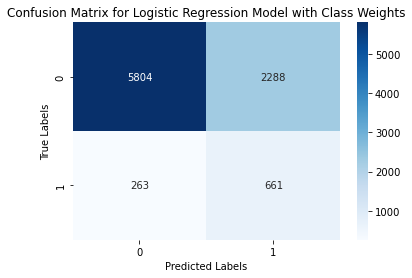

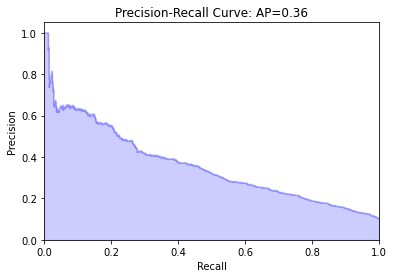

In [29]:
# Create a Logistic Regression model with class weights
lr1 = LogisticRegression(class_weight='balanced')

# Train the model on the imbalanced dataset
lr1.fit(X_train, Y_train)


# Evaluate the model performance
y_pred = lr1.predict(X_test)
y_pred_prob = lr1.predict_proba(X_test)

# Get the classification report
print("Classification Report:\n", classification_report(Y_test, y_pred))

# Get the precision-recall curve
y_score1 = lr1.decision_function(X_test)
average_precision1 = average_precision_score(Y_test, y_score1)
precision1, recall1, _ = precision_recall_curve(Y_test, y_score1)

# Generate confusion matrix
cm2 = confusion_matrix(Y_test, y_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model with Class Weights')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall1, precision1, color='b', alpha=0.2, where='post')
plt.fill_between(recall1, precision1, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision1))
plt.show()

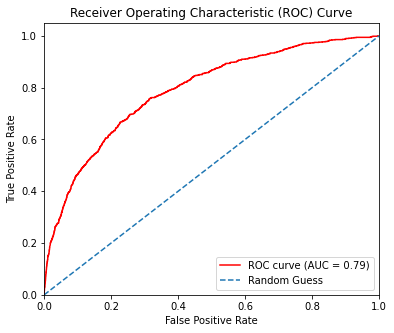

In [30]:
from sklearn.metrics import auc
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='red')
plt.plot([0, 1], [0, 1], '--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


For Positive class, the precision is 0.22, which means that out of all the shots predicted as goal, only 22% are actually went in. The recall is 0.72, which means that out of all the actual instances of 1, 72% are correctly predicted as 1.

The accuracy of the model is 0.72, which means that 72% of the instances are correctly classified by the model. The accuracies took a hit since the accuracies were much better in the initial Logistic Regression. Let us try Resampling method.

#### Resampling

In [31]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Create resampling objects
over_sampler = RandomOverSampler()
under_sampler = RandomUnderSampler()

# Resample the training data
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, Y_train)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_resampled, y_train_resampled)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82      8092
           1       0.23      0.72      0.34       924

    accuracy                           0.72      9016
   macro avg       0.59      0.72      0.58      9016
weighted avg       0.88      0.72      0.77      9016



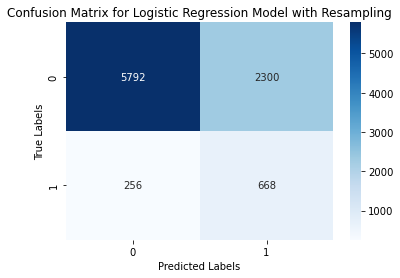

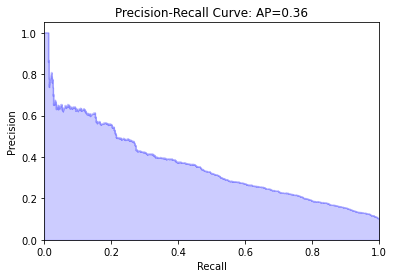

In [32]:
lr2 = LogisticRegression()

# Train the model on the imbalanced dataset
lr2.fit(X_train_resampled, y_train_resampled)


# Evaluate the model performance
y1_pred = lr2.predict(X_test)
y1_pred_prob = lr2.predict_proba(X_test)


# Get the classification report
print("Classification Report:\n", classification_report(Y_test, y1_pred))

# Get the precision-recall curve
y_score2 = lr2.decision_function(X_test)
average_precision2 = average_precision_score(Y_test, y_score2)
precision2, recall2, _ = precision_recall_curve(Y_test, y_score2)

# Generate confusion matrix
cm3 = confusion_matrix(Y_test, y1_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm3, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model with Resampling')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall2, precision2, color='b', alpha=0.2, where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision2))
plt.show()

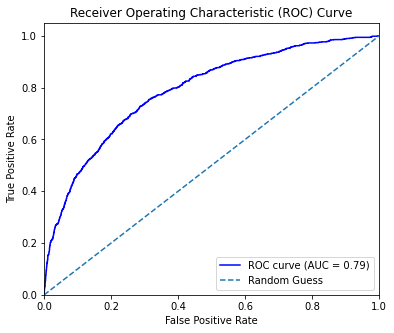

In [33]:
from sklearn.metrics import auc
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y1_pred_prob[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='blue')
plt.plot([0, 1], [0, 1], '--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


We can see similar results in case of resampling method as well where the recall went up to 72% at the cost of recall of the negative class. Let's try Synthetic Resampling as well!

#### Synthetic Resampling

In [34]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
sm = SMOTE()

# Resample the training data using SMOTE
X_train_resampled_smote, y_train_resampled_smote = sm.fit_resample(X_train, Y_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.71      0.82      8092
           1       0.22      0.72      0.34       924

    accuracy                           0.72      9016
   macro avg       0.59      0.72      0.58      9016
weighted avg       0.88      0.72      0.77      9016



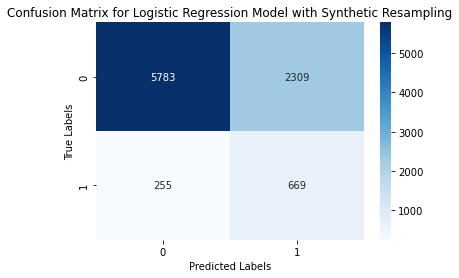

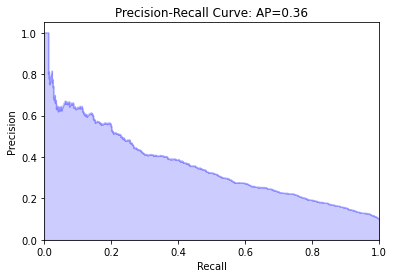

In [35]:
lr3 = LogisticRegression()

# Train the model on the imbalanced dataset
lr3.fit(X_train_resampled_smote, y_train_resampled_smote)


# Evaluate the model performance
y2_pred = lr3.predict(X_test)
y2_pred_prob = lr3.predict_proba(X_test)


# Get the classification report
print("Classification Report:\n", classification_report(Y_test, y2_pred))

# Get the precision-recall curve
y_score3 = lr3.decision_function(X_test)
average_precision3 = average_precision_score(Y_test, y_score3)
precision3, recall3, _ = precision_recall_curve(Y_test, y_score3)

# Generate confusion matrix
cm4 = confusion_matrix(Y_test, y2_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm4, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model with Synthetic Resampling')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall3, precision3, color='b', alpha=0.2, where='post')
plt.fill_between(recall3, precision3, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision3))
plt.show()

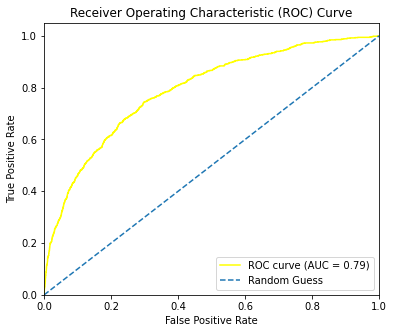

In [36]:
from sklearn.metrics import auc
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y2_pred_prob[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='yellow')
plt.plot([0, 1], [0, 1], '--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Even though we get a similar result for synthetic resampling, these findings are significantly more encouraging! The recall metrics for the 'goal' situations have significantly improved, although it has been at the cost of the 'no goal' category. It appears that this approach is moving in the right direction, at the very least!


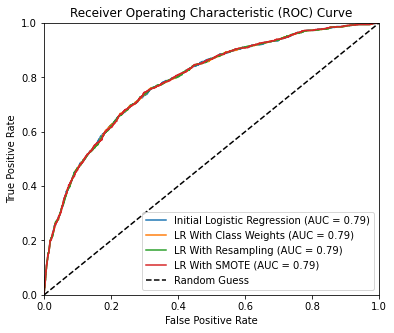

In [37]:
# Get the predicted probabilities for each model
y_pred_prob_model1 = lr.predict_proba(X_test)[:, 1]
y_pred_prob_model2 = lr1.predict_proba(X_test)[:, 1]
y_pred_prob_model3 = lr2.predict_proba(X_test)[:, 1]
y_pred_prob_model4 = lr3.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC for each model
fpr_model1, tpr_model1, _ = roc_curve(Y_test, y_pred_prob_model1)
roc_auc_model1 = auc(fpr_model1, tpr_model1)

fpr_model2, tpr_model2, _ = roc_curve(Y_test, y_pred_prob_model2)
roc_auc_model2 = auc(fpr_model2, tpr_model2)

fpr_model3, tpr_model3, _ = roc_curve(Y_test, y_pred_prob_model3)
roc_auc_model3 = auc(fpr_model3, tpr_model3)

fpr_model4, tpr_model4, _ = roc_curve(Y_test, y_pred_prob_model4)
roc_auc_model4 = auc(fpr_model4, tpr_model4)

# Plot the ROC curve for each model
plt.figure(figsize=(6, 5))
plt.plot(fpr_model1, tpr_model1, label='Initial Logistic Regression (AUC = %0.2f)' % roc_auc_model1)
plt.plot(fpr_model2, tpr_model2, label='LR With Class Weights (AUC = %0.2f)' % roc_auc_model2)
plt.plot(fpr_model3, tpr_model3, label='LR With Resampling (AUC = %0.2f)' % roc_auc_model3)
plt.plot(fpr_model4, tpr_model4, label='LR With SMOTE (AUC = %0.2f)' % roc_auc_model4)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

As we are trying different classification algorithms, let us also try Naive Bayes Model. Naive Bayes is a probabilistic classification algorithm that uses Bayes' theorem with the "naive" assumption of independence between every pair of features. 

### Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB

# splitting test and train data
X = normalized_df.drop(columns=['Goal'])
Y = normalized_df['Goal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and fit the Naive Bayes model
nb = GaussianNB()

# Cross-validation
cv_scores = cross_val_score(nb, X_train, Y_train, cv=10)


# Calculate the mean of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
print("Mean Cross-Validation Score:", mean_cv_score)

# Fit the model on the training set
nb.fit(X_train, Y_train)

# Make predictions on the testing set
Y_pred = nb.predict(X_test)
Y_pred_prob = nb.predict_proba(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Mean Cross-Validation Score: 0.8247836254180683
Accuracy: 0.8320763087843833


Cross-validation accuracy: 0.8240905057675245
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90      8120
           1       0.27      0.40      0.32       896

    accuracy                           0.83      9016
   macro avg       0.60      0.64      0.61      9016
weighted avg       0.86      0.83      0.85      9016



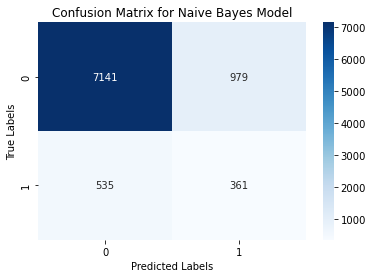

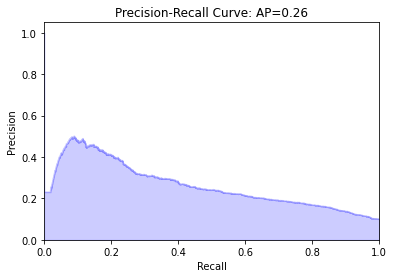

In [37]:
# Fit the model with cross-validation
scores = cross_val_score(nb, X, Y, cv=10, scoring='accuracy')
print('Cross-validation accuracy:', scores.mean())

# Get the classification report
y_pred = nb.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))

# Get the confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

# Get the precision-recall curve
y_score = nb.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(Y_test, y_score)
precision, recall, _ = precision_recall_curve(Y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
plt.show()

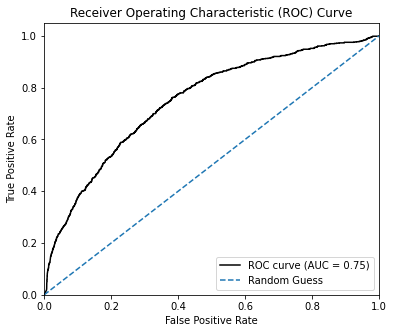

In [38]:
from sklearn.metrics import auc
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob[:, 1])

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='black')
plt.plot([0, 1], [0, 1], '--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The Naive Bayes model appears to have low precision and recall for positive class (1 being the minority class), which indicates that the model is not performing well in correctly identifying instances of that class. Upon further investigating, we can come up with 2 conclusions. Imbalanced dataset is affecting the performance of the model. A model trained on the imbalanced dataset may be biased towards the majority class, leading to poor performance on the minority class. Naive Bayes assumes that all features are independent of each other, which may not be true in real-world datasets. Violation of this assumption can lead to inaccurate predictions. So, Naive Bayes was not a good choice after all!

### K-Nearest Neighbour Model

We also take a look at KNN Algorithm. The K-Nearest Neighbors (KNN) algorithm is a type of supervised learning algorithm that can be used for both classification and regression tasks. One of the main advantages of the KNN algorithm is its simplicity and ease of implementation. 

Accuracy: 0.8935226264418811
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      8120
           1       0.39      0.13      0.20       896

    accuracy                           0.89      9016
   macro avg       0.65      0.56      0.57      9016
weighted avg       0.86      0.89      0.87      9016



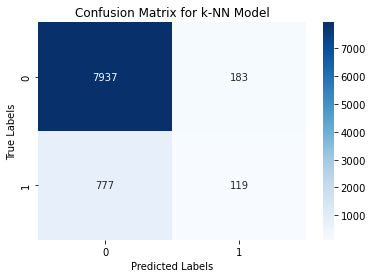

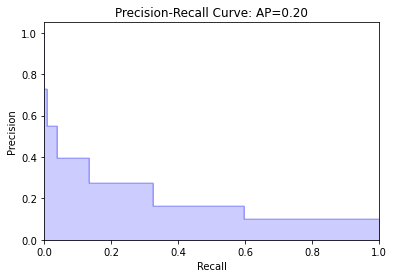

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the k-NN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Evaluate the performance of the model using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for k-NN Model')
plt.show()

# Get the precision-recall curve
y_score = knn.predict_proba(X_test)[:,1]
average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)

# Plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
plt.show()

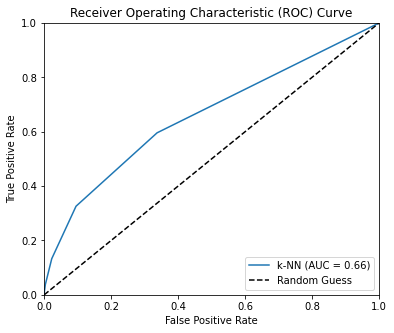

In [42]:
# Get the predicted probabilities for the k-NN model
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC for the k-NN model
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

# Plot the ROC curve for the k-NN model
plt.figure(figsize=(6, 5))
plt.plot(fpr_knn, tpr_knn, label='k-NN (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The KNN model appears to have a higher overall accuracy than the Naive Bayes model, with an accuracy of 0.89 compared to 0.83 for Naive Bayes. However, it has lower precision, recall, and F1-score for class 1 (1 being the minority class) than Naive Bayes, indicating that the KNN model is not performing as well as Naive Bayes in correctly identifying the goals.

In general, the performance of the KNN model may be affected by the choice of the number of neighbors (k), which is 5 in our case, the distance metric used to measure similarity between instances, and the scaling or normalization of the features. 

### Random Forest Model


As we saw earlier, ensemble methods can be particularly useful on imbalanced data because they can help to address the issue of bias towards the majority class. Random Forest is a popular ensemble method that uses a collection of decision trees to make predictions. Each decision tree is trained on a different subset of the data, and the predictions of the individual trees are combined to make the final prediction. Random Forest models are also the most well-known and straightforward class of models in the field of Machine Learning.

#### Fitting an initial Random Forest Model

In [38]:
features = shots_model[['X', 'Y', 'side_of_field', 'left_foot', 'right_foot', 'header', 'counter_attack', 'strong_foot', 'C',
                "Distance", 'Angle', 'out_swinging', 'in_swinging', 'rebound', 'prev_cross', 'prev_touch',
       'prev_pass', 'prev_smart_pass', 'free_kick', 'prev_duel', "matchPeriod"]]


In [39]:
features

,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,...,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,matchPeriod
0,9,29,1,0,1,0,0,0,21.0,17.123694,...,0,1,0,0,0,1,0,0,0,0
1,29,29,1,0,1,0,0,1,21.0,33.632141,...,0,1,0,0,0,1,0,0,0,0
2,4,57,0,0,1,0,0,1,7.0,6.348039,...,1,0,0,0,0,0,0,0,1,0
3,4,61,0,0,0,1,0,0,11.0,8.578485,...,0,0,0,0,0,0,0,0,1,0
4,25,33,1,1,0,0,0,1,17.0,28.682679,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45279,5,45,1,1,0,0,0,1,5.0,6.254798,...,1,0,0,0,1,0,0,0,0,1
45280,7,38,1,1,0,0,0,1,12.0,10.982172,...,1,0,0,0,0,0,1,0,0,1
45281,10,46,1,1,0,0,0,1,4.0,10.846585,...,1,0,0,0,0,0,0,0,1,1
45282,21,32,1,0,1,0,0,1,18.0,25.219439,...,0,1,0,0,0,1,0,0,0,1


In [40]:
labels = shots_model['Goal']

In [41]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
45279    0
45280    0
45281    1
45282    0
45283    0
Name: Goal, Length: 45080, dtype: int64

In [42]:
# splitting test and train data
X = normalized_df.drop(columns=['Goal'])
Y = normalized_df['Goal']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [43]:
naive_rf_model=RandomForestClassifier(random_state=42)

In [44]:
naive_rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
train_y_hat=naive_rf_model.predict_proba(X_train)
naive_train_log_loss=log_loss(y_train, train_y_hat[:,1])
naive_train_roc_auc=roc_auc_score(y_train, train_y_hat[:,1])
print('The log loss of our model on the training set is : ' +str(round(naive_train_log_loss, 4)))
print('The ROC AUC of our model on the training set is : ' +str(round(naive_train_roc_auc, 3)))

The log loss of our model on the training set is : 0.1214
The ROC AUC of our model on the training set is : 0.981


In [47]:
test_y_hat=naive_rf_model.predict_proba(X_test)
naive_test_log_loss=log_loss(y_test, test_y_hat[:,1])
naive_test_roc_auc=roc_auc_score(y_test, test_y_hat[:,1])
print('The log loss of our model on the test set is : ' +str(round(naive_test_log_loss, 4)))
print('The ROC AUC of our model on the test set is : ' +str(round(naive_test_roc_auc, 3)))

The log loss of our model on the test set is : 0.7242
The ROC AUC of our model on the test set is : 0.698


In [46]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat[:,1])

NameError: name 'test_y_hat' is not defined

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      8120
           1       0.31      0.16      0.21       896

    accuracy                           0.88      9016
   macro avg       0.61      0.56      0.57      9016
weighted avg       0.85      0.88      0.86      9016



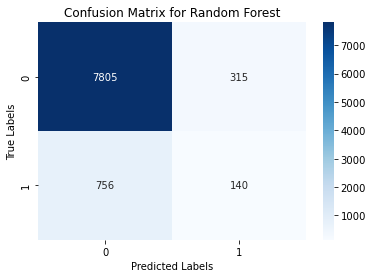

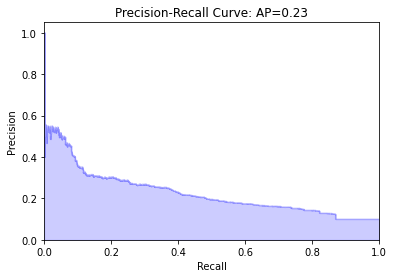

In [47]:
y_pred3 = naive_rf_model.predict(X_test)
y_pred3_prob = naive_rf_model.predict_proba(X_test)


report3 = classification_report(y_test, y_pred3)
print(report3)

# Get the precision-recall curve
y_score6 = naive_rf_model.predict_proba(X_test)[:, 1]
average_precision6 = average_precision_score(y_test, y_score6)
precision6, recall6, _ = precision_recall_curve(y_test, y_score6)

# Generate confusion matrix
cm7 = confusion_matrix(y_test, y_pred3)

# Create heatmap of confusion matrix
sns.heatmap(cm7, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall6, precision6, color='b', alpha=0.2, where='post')
plt.fill_between(recall6, precision6, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision6))
plt.show()

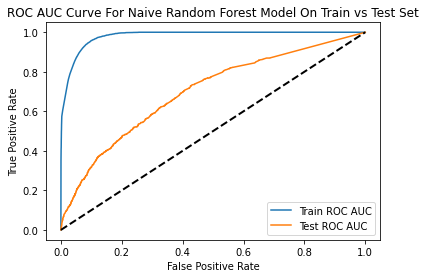

In [50]:
plt.plot(train_fpr, train_tpr, label='Train ROC AUC')
plt.plot(test_fpr, test_tpr, label='Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Random Forest Model On Train vs Test Set')
plt.show()

### Random Forest Hyperparameters

#### Random Search

In [51]:
#Initialize models:
random_search_model = RandomForestClassifier(random_state=42)
grid_search_model = RandomForestClassifier(random_state=42)

#Set up the cross validation folds
cv_split = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [52]:
#Set up the grid to pick hyperparameters from:
rf_hyperparam_grid={
    "n_estimators": [100, 200],
    "max_features": ['auto', 7, 10, 15],
    "min_samples_leaf": [1, 5, 20, 100],
    "min_samples_split": [2, 10, 50, 250],
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 6, 8, 10, None]
}

In [53]:
#Initialize the Random Search:
rf_random_search=RandomizedSearchCV(
    estimator=random_search_model,
    param_distributions=rf_hyperparam_grid,
    n_iter=100,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=42
)

In [54]:
%time tuned_random_model = rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 4.03 s
Wall time: 6min 52s


In [55]:
tuned_random_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 250,
 'min_samples_leaf': 20,
 'max_features': 10,
 'max_depth': 8,
 'criterion': 'gini'}

In [56]:
random_y_hat = tuned_random_model.predict_proba(X_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, random_y_hat)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, random_y_hat[:,1])))

The log loss of the model with Random Search is: 0.2684634258175108
The ROC AUC score of the model with Random Search is: 0.7872237310872625


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8120
           1       0.65      0.10      0.17       896

    accuracy                           0.91      9016
   macro avg       0.78      0.55      0.56      9016
weighted avg       0.88      0.91      0.87      9016



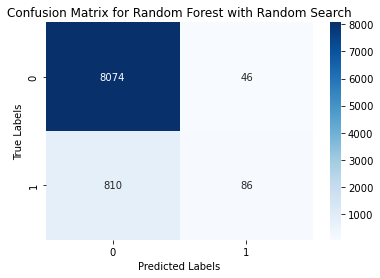

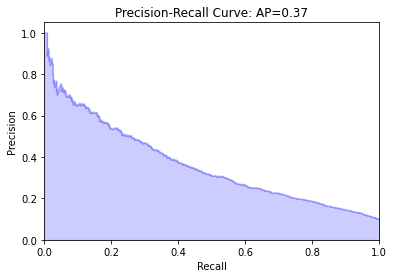

In [57]:
y_pred1 = tuned_random_model.predict(X_test)
y_pred1_prob = tuned_random_model.predict_proba(X_test)


report5 = classification_report(y_test, y_pred1)
print(report5)

# Get the precision-recall curve
y_score4 = tuned_random_model.predict_proba(X_test)[:, 1]
average_precision4 = average_precision_score(y_test, y_score4)
precision4, recall4, _ = precision_recall_curve(y_test, y_score4)

# Generate confusion matrix
cm5 = confusion_matrix(y_test, y_pred1)

# Create heatmap of confusion matrix
sns.heatmap(cm5, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest with Random Search')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall4, precision4, color='b', alpha=0.2, where='post')
plt.fill_between(recall4, precision4, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision4))
plt.show()

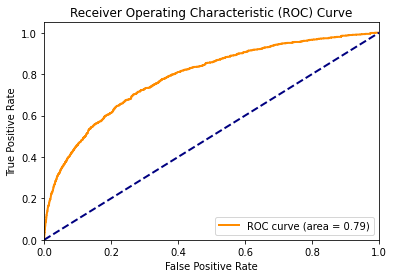

In [63]:
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_test, y_score4)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Grid Search

In [58]:
rf_grid_search=GridSearchCV(
    estimator=grid_search_model,
    param_grid=rf_hyperparam_grid,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,
    verbose=10,
    n_jobs=-1,
)

In [59]:
%time tuned_grid_model = rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
CPU times: total: 36.4 s
Wall time: 11h 18min 59s


In [60]:
tuned_grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 250,
 'n_estimators': 200}

In [61]:
grid_y_hat = tuned_grid_model.predict_proba(X_test)
print("The log loss of the model with Grid Search is: " + str(log_loss(y_test, grid_y_hat)))
print("The ROC AUC score of the model with Grid Search is: " +str(roc_auc_score(y_test, grid_y_hat[:,1])))

The log loss of the model with Grid Search is: 0.26827912773693086
The ROC AUC score of the model with Grid Search is: 0.7882002248636524


Predicted goals (test set): 125
Sum of predicted goal probabilities (aka xG): 928.46
Actual goals (test set): 896
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8120
           1       0.66      0.09      0.16       896

    accuracy                           0.91      9016
   macro avg       0.79      0.54      0.56      9016
weighted avg       0.88      0.91      0.87      9016



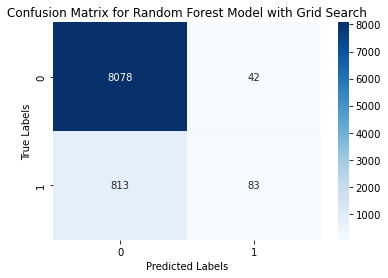

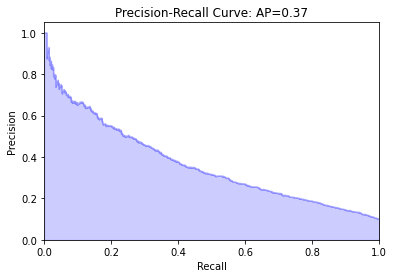

In [62]:
y_pred2 = tuned_grid_model.predict(X_test)
y_pred2_prob = tuned_grid_model.predict_proba(X_test)

print("Predicted goals (test set):", sum(y_pred2))
print("Sum of predicted goal probabilities (aka xG):", "{0:.2f}".format(sum(y_pred2_prob[:,1])))
print("Actual goals (test set):", sum(y_test))


report2 = classification_report(y_test, y_pred2)
print(report2)


# Get the precision-recall curve
y_score5 = tuned_grid_model.predict_proba(X_test)[:, 1]
average_precision5 = average_precision_score(y_test, y_score5)
precision5, recall5, _ = precision_recall_curve(y_test, y_score5)

# Generate confusion matrix
cm6 = confusion_matrix(y_test, y_pred2)

# Create heatmap of confusion matrix
sns.heatmap(cm6, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model with Grid Search')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall5, precision5, color='b', alpha=0.2, where='post')
plt.fill_between(recall5, precision5, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision5))
plt.show()

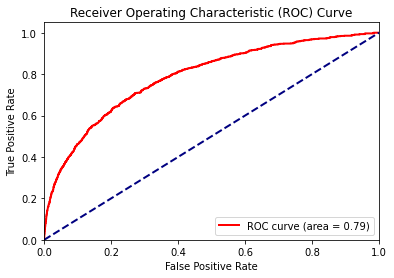

In [64]:
# Compute ROC curve and ROC area for each class
fpr, tpr, threshold = roc_curve(y_test, y_score5)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Let's plot the ROC-AUC curves as well to compare this model to the naive model above

In [65]:
random_fpr, random_tpr, random_thresholds = roc_curve(y_true=y_test, y_score=random_y_hat[:,1])
grid_fpr, grid_tpr, grid_thresholds = roc_curve(y_true=y_test, y_score=grid_y_hat[:,1])

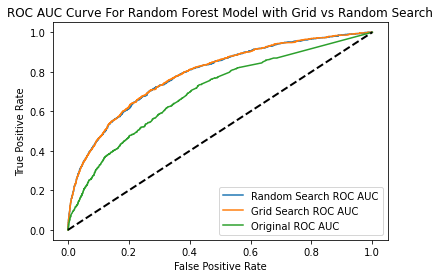

In [69]:
plt.plot(random_fpr, random_tpr, label='Random Search ROC AUC')
plt.plot(grid_fpr, grid_tpr, label='Grid Search ROC AUC')
plt.plot(test_fpr, test_tpr, label='Original ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Random Forest Model with Grid vs Random Search')
plt.show()

### Partial Dependence Plots For Hyperparameters

Now let's analyze how the accuracy of our model changes as we modify each parameter on both the training and testing data. This will help us understand how these parameters influence overfitting. Moreover, it will help us see how accurate the Random Search was in determining the optimal parameters on a separate dataset from the testing set. To prevent overfitting to our testing set, we will create a validation set, which will be a portion of the original training set.


In [67]:
x_train_2, x_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [68]:
initial_random_forest_model = RandomForestClassifier(n_estimators=500,
                                                     min_samples_split=250,
                                                     min_samples_leaf=5,
                                                     max_features=7,
                                                     max_depth=8,
                                                     criterion='gini',
                                                     n_jobs=-1)

In [70]:
#n_estimators: 0-1000, increasing by 20 each time
n_estimators_x_axis=np.linspace(20, 800, 40).astype(int)
n_estimators_train_loss=[]
n_estimators_test_loss=[]
for estimators in n_estimators_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"n_estimators": estimators})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    n_estimators_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    n_estimators_test_loss.append(log_loss(y_val, test_predict[:,-1]))

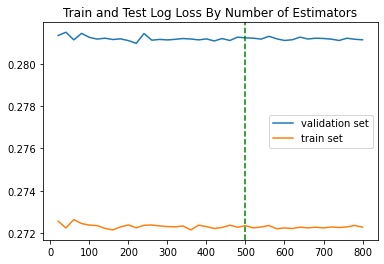

In [71]:
plt.plot(n_estimators_x_axis, n_estimators_test_loss,label='validation set')
plt.plot(n_estimators_x_axis, n_estimators_train_loss,label='train set')
plt.legend()
plt.axvline(x=500, color='green', linestyle='--')
plt.title('Train and Test Log Loss By Number of Estimators')
plt.show()

In [72]:
initial_random_forest_model.set_params(**{"n_estimators": 500})

RandomForestClassifier(max_depth=8, max_features=7, min_samples_leaf=5,
                       min_samples_split=250, n_estimators=500, n_jobs=-1)

In [73]:
#Depth: #1-20
max_depth_x_axis=np.linspace(1, 20, 20).astype(int)
max_depth_train_loss=[]
max_depth_test_loss=[]

for depth in max_depth_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"max_depth": depth})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    max_depth_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    max_depth_test_loss.append(log_loss(y_val, test_predict[:,-1]))

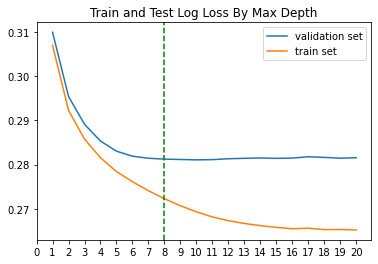

In [74]:
plt.plot(max_depth_x_axis, max_depth_test_loss,label='validation set')
plt.plot(max_depth_x_axis, max_depth_train_loss,label='train set')
plt.legend()
plt.axvline(x=8, color='green', linestyle='--')
plt.xticks(np.arange(21))
plt.title('Train and Test Log Loss By Max Depth')
plt.show()

In [75]:
initial_random_forest_model.set_params(**{"max_depth": 8})

RandomForestClassifier(max_depth=8, max_features=7, min_samples_leaf=5,
                       min_samples_split=250, n_estimators=500, n_jobs=-1)

In [76]:
#max_features: 0-18
max_features_x_axis=np.linspace(1, 17, 17).astype(int)
max_features_train_loss=[]
max_features_test_loss=[]

for features in max_features_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"max_features": features})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    max_features_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    max_features_test_loss.append(log_loss(y_val, test_predict[:,-1]))

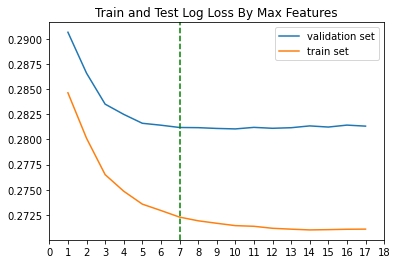

In [77]:
plt.plot(max_features_x_axis, max_features_test_loss,label='validation set')
plt.plot(max_features_x_axis, max_features_train_loss,label='train set')
plt.legend()
plt.axvline(x=7, color='green', linestyle='--')
plt.xticks(np.arange(19))
plt.title('Train and Test Log Loss By Max Features')
plt.show()

In [78]:
initial_random_forest_model.set_params(**{"max_features": 7})

RandomForestClassifier(max_depth=8, max_features=7, min_samples_leaf=5,
                       min_samples_split=250, n_estimators=500, n_jobs=-1)

In [79]:
#min_samples_leaf: 1-100, increase by 3:
min_samples_leaf_x_axis=np.linspace(1, 100, 34).astype(int)
min_samples_leaf_train_loss=[]
min_samples_leaf_test_loss=[]

for samples in min_samples_leaf_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"min_samples_leaf": samples})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    min_samples_leaf_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    min_samples_leaf_test_loss.append(log_loss(y_val, test_predict[:,-1]))

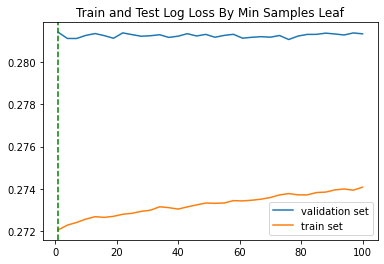

In [80]:
plt.plot(min_samples_leaf_x_axis, min_samples_leaf_test_loss,label='validation set')
plt.plot(min_samples_leaf_x_axis, min_samples_leaf_train_loss,label='train set')
plt.legend()
plt.axvline(x=1, color='green', linestyle='--')
plt.title('Train and Test Log Loss By Min Samples Leaf')
plt.show()

It seems that this parameter has minimal impact on the predictions of the model on the test set.

In [81]:
initial_random_forest_model.set_params(**{"min_samples_leaf": 1})

RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=250,
                       n_estimators=500, n_jobs=-1)

In [82]:
#min_samples_split: 0-500, increasing by 20 each time
min_samples_split_x_axis=np.linspace(25, 600, 25).astype(int)
min_samples_split_train_loss=[]
min_samples_split_test_loss=[]

for samples in min_samples_split_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"min_samples_split": samples})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    min_samples_split_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    min_samples_split_test_loss.append(log_loss(y_val, test_predict[:,-1]))

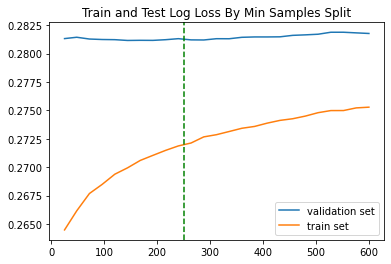

In [83]:
plt.plot(min_samples_split_x_axis, min_samples_split_test_loss,label='validation set')
plt.plot(min_samples_split_x_axis, min_samples_split_train_loss,label='train set')
plt.legend()
plt.axvline(x=250, color='green', linestyle='--')
plt.title('Train and Test Log Loss By Min Samples Split')
plt.show()

In [84]:
initial_random_forest_model.set_params(**{"min_samples_split": 250})

RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=250,
                       n_estimators=500, n_jobs=-1)

In [85]:
RF_model=initial_random_forest_model

In [86]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=250,
                       n_estimators=500, n_jobs=-1)

In [159]:
# Get feature importances
importances = RF_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, importances):
    print(f'{feature}: {importance}')

left_foot: 0.006119537120292171
right_foot: 0.006198221529345128
header: 0.06291628533342575
counter_attack: 0.011664164570747494
strong_foot: 0.018260042463803545
C: 0.05208461284224673
Distance: 0.45023276294831266
Angle: 0.31581466078487297
out_swinging: 0.00894302676521024
in_swinging: 0.004333277505951199
rebound: 0.005007760432992277
prev_cross: 0.009310273944827575
prev_touch: 0.0025707460696099155
prev_pass: 0.003694865595533441
prev_smart_pass: 0.014385225442334197
free_kick: 0.0043774890319160445
prev_duel: 0.020228421568049788
matchPeriod: 0.003858626050528875


### XGBoost

In [48]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create an instance of the XGBClassifier
clf = xgb.XGBClassifier()

# Train the model using log loss as the evaluation metric
clf.fit(X_train, y_train, eval_metric='logloss')

# Make predictions on the test set
y_pred_proba = clf.predict_proba(X_test)[:,1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC score of the model with XGBoost is:", roc_auc)

# Calculate the log loss
logloss = log_loss(y_test, y_pred_proba)
print("The log loss of the model with XGBoost is:", logloss)


ROC AUC score of the model with XGBoost is: 0.7692890679978888
The log loss of the model with XGBoost is: 0.2784417401184725


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8120
           1       0.58      0.10      0.17       896

    accuracy                           0.90      9016
   macro avg       0.75      0.55      0.56      9016
weighted avg       0.88      0.90      0.87      9016



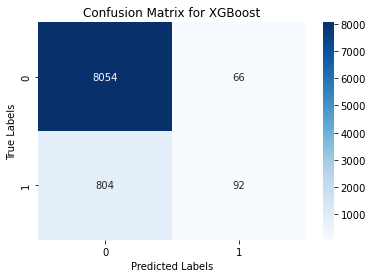

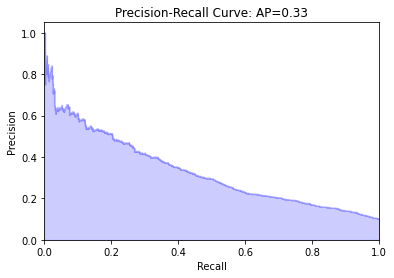

In [49]:
y_pred10 = clf.predict(X_test)
y_pred10_prob = clf.predict_proba(X_test)

report10 = classification_report(y_test, y_pred10)
print(report10)


# Get the precision-recall curve
average_precision10 = average_precision_score(y_test, y_pred_proba)
precision10, recall10, _ = precision_recall_curve(y_test, y_pred_proba)

# Generate confusion matrix
cm10 = confusion_matrix(y_test, y_pred10)

# Create heatmap of confusion matrix
sns.heatmap(cm10, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall10, precision10, color='b', alpha=0.2, where='post')
plt.fill_between(recall10, precision10, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision10))
plt.show()

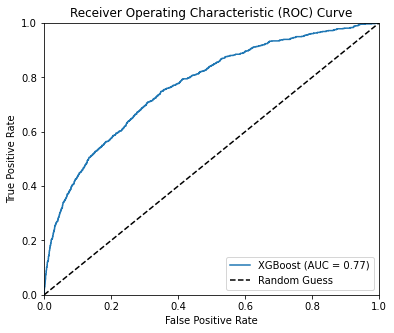

In [89]:
# Calculate the ROC curve and AUC for the XGBoost model
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve for the XGBoost model
plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Confusion matrix for fold:
[[8024   68]
 [ 816  108]]
Confusion matrix for fold:
[[7988  104]
 [ 827   97]]
Confusion matrix for fold:
[[8001   91]
 [ 828   96]]
Confusion matrix for fold:
[[8020   72]
 [ 829   95]]
Confusion matrix for fold:
[[8014   78]
 [ 817  107]]
Mean ROC AUC score:  0.7625196602705253
Mean log loss:  0.288785218646578


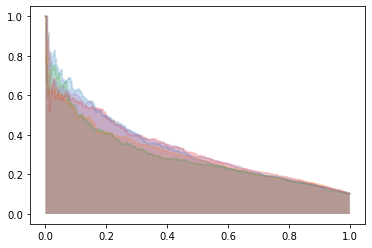

In [180]:
# splitting data into X and Y
X = normalized_df.drop(columns=['Goal'])
Y = normalized_df['Goal']

# Create an instance of the XGBClassifier
clf = xgb.XGBClassifier()

# Set up the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define arrays to store scores
roc_auc_scores = []
logloss_scores = []

# Perform cross-validation
for train_index, test_index in skf.split(X, Y):
    # Get the training and test data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Train the model using log loss as the evaluation metric
    clf.fit(X_train, y_train, eval_metric='logloss')
    
    # Make predictions on the test set
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    
    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores.append(roc_auc)
    
    # Calculate the log loss
    logloss = log_loss(y_test, y_pred_proba)
    logloss_scores.append(logloss)
    
    # Generate confusion matrix
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix for fold:")
    print(cm)
    
    # Get the precision-recall curve
    average_precision = average_precision_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Plot the precision-recall curve
    plt.step(recall, precision, alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2)
    
# Calculate the mean ROC AUC score and log loss
mean_roc_auc = np.mean(roc_auc_scores)
mean_logloss = np.mean(logloss_scores)

# Print the results
print("Mean ROC AUC score: ", mean_roc_auc)
print("Mean log loss: ", mean_logloss)


#### Hyperparameter Tuning of XGBoost

In [181]:
#Set up the grid to pick hyperparameters from:
xgb_hyperparam_grid={
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'n_estimators': [50, 100, 150],
    'scale_pos_weight': [1, 10, 25, 50]
}

In [182]:
random_search_model_xgb = XGBClassifier(random_state=42)

#Initialize the Random Search:
xgb_random_search=RandomizedSearchCV(
    estimator=random_search_model_xgb,
    param_distributions=xgb_hyperparam_grid,
    n_iter=100,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=42
)

In [183]:
%time tuned_random_model_xgb = xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 14.3 s
Wall time: 6min 46s


In [184]:
tuned_random_model_xgb.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 1,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 1}

In [185]:
random_y_hat_xgb = tuned_random_model_xgb.predict_proba(X_test)
print("The log loss of the model with Random Search XGB is: " + str(log_loss(y_test, random_y_hat_xgb)))
print("The ROC AUC score of the model with Random Search XGB is: " +str(roc_auc_score(y_test, random_y_hat_xgb[:,1])))

The log loss of the model with Random Search XGB is: 0.27674293752787377
The ROC AUC score of the model with Random Search XGB is: 0.7827209092193027


In [187]:
# Get feature importances
importances = tuned_random_model_xgb.best_estimator_.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, importances):
    print(f'{feature}: {importance}')

left_foot: 0.04123157262802124
right_foot: 0.03239000216126442
header: 0.15992605686187744
counter_attack: 0.05587175861001015
strong_foot: 0.044374238699674606
C: 0.03915007412433624
Distance: 0.10433857142925262
Angle: 0.10845209658145905
out_swinging: 0.03548816964030266
in_swinging: 0.03183743357658386
rebound: 0.04179604351520538
prev_cross: 0.049744319170713425
prev_touch: 0.03694632276892662
prev_pass: 0.03939967602491379
prev_smart_pass: 0.05809841305017471
free_kick: 0.041038572788238525
prev_duel: 0.04626040160655975
matchPeriod: 0.03365637734532356


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8092
           1       0.63      0.12      0.20       924

    accuracy                           0.90      9016
   macro avg       0.77      0.55      0.57      9016
weighted avg       0.88      0.90      0.87      9016



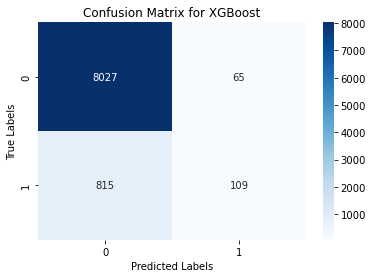

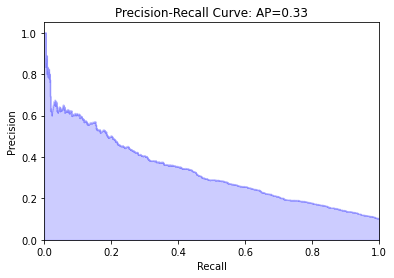

In [188]:
y_pred11 = tuned_random_model_xgb.predict(X_test)
y_pred11_prob = tuned_random_model_xgb.predict_proba(X_test)

report11 = classification_report(y_test, y_pred11)
print(report11)


# Get the precision-recall curve
y_score11 = clf.predict_proba(X_test)[:, 1]
average_precision11 = average_precision_score(y_test, y_score11)
precision11, recall11, _ = precision_recall_curve(y_test, y_score11)

# Generate confusion matrix
cm11 = confusion_matrix(y_test, y_pred11)

# Create heatmap of confusion matrix
sns.heatmap(cm11, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall11, precision11, color='b', alpha=0.2, where='post')
plt.fill_between(recall11, precision11, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision11))
plt.show()

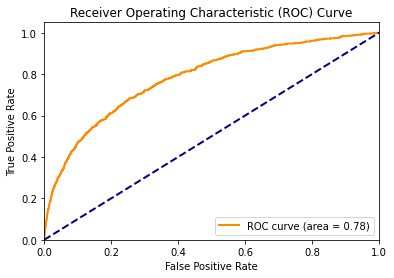

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities and calculate the ROC curve and AUC
y_pred11_prob = tuned_random_model_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred11_prob)
roc_auc = roc_auc_score(y_test, y_pred11_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Support Vector Machine

Let's try Support Vector Machine as well. Since SVM is good for binary class classification, we might get a good performance.

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



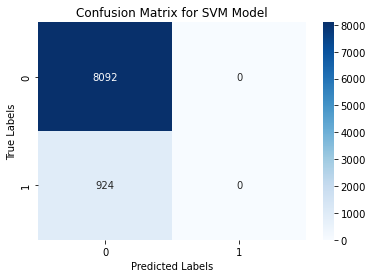

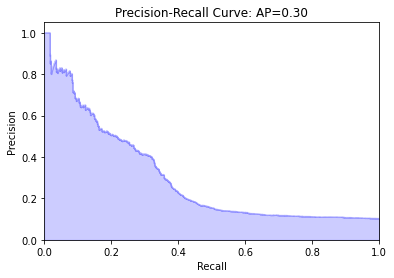

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



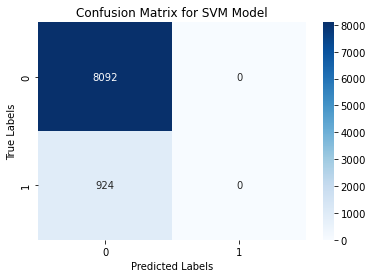

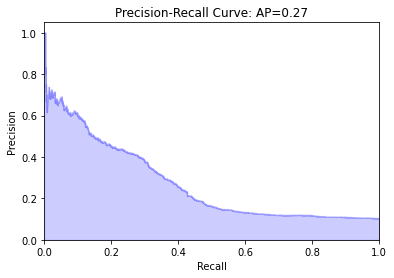

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



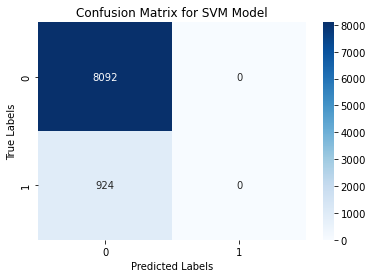

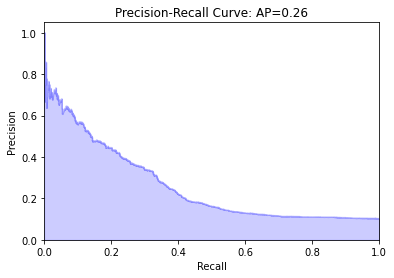

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



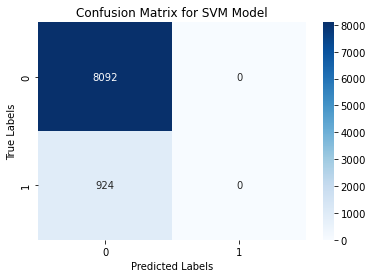

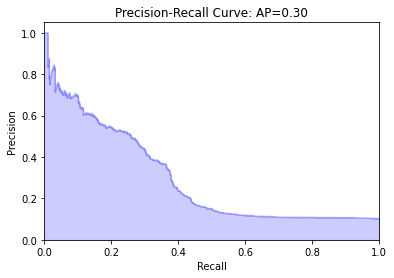

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



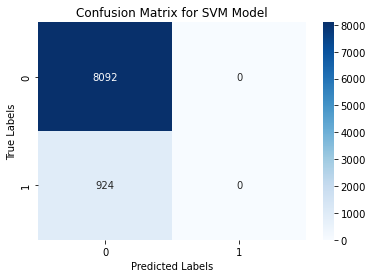

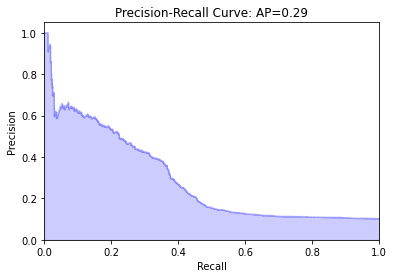

Mean accuracy: 0.8975155279503106
Standard deviation: 1.1102230246251565e-16


In [112]:
from sklearn.svm import SVC

X = normalized_df.drop(columns=['Goal'])
y = normalized_df['Goal']

# Create a stratified k-fold cross-validator with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the cross-validation scores
scores = []

# Initialize a list to store the predicted probabilities
y_prob = []

# Train and evaluate an SVM model for each fold
for train_idx, test_idx in skf.split(X, y):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train an SVM model with a radial basis function (RBF) kernel
    clf = SVC(kernel='rbf', gamma=0.1, C=1, probability=True)
    clf.fit(X_train, y_train)

    # Make predictions on the testing set for this fold
    y_pred = clf.predict(X_test)
    y_prob.append(clf.predict_proba(X_test))

    # Evaluate the model's performance for this fold
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

    # Get the classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create heatmap of confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVM Model')
    plt.show()

    # Get the precision-recall curve
    y_score = clf.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # Plot the precision-recall curve
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = sum(scores) / len(scores)
std_score = np.std(scores)
print('Mean accuracy:', mean_score)
print('Standard deviation:', std_score)

# Calculate the mean predicted probabilities
y_prob_mean = np.mean(y_prob, axis=0)

### Hyperparameter Tuning Using Grid Search

In [ ]:
X = normalized_df.drop(columns=['Goal'])
y = normalized_df['Goal']

# Set up the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize an SVM classifier
svc = SVC()

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X, y)

# Print the best hyperparameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



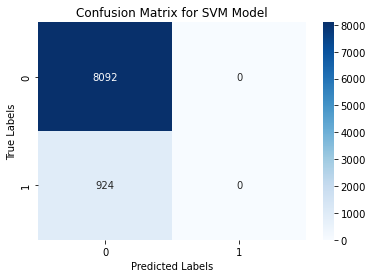

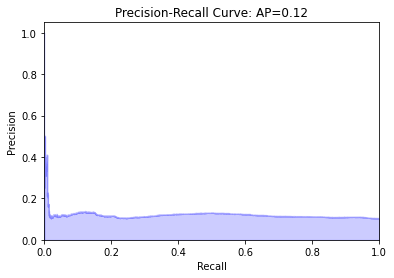

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



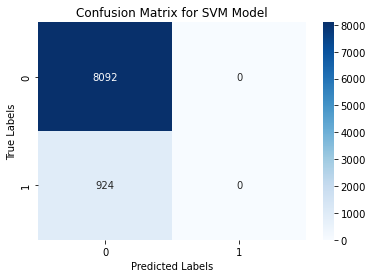

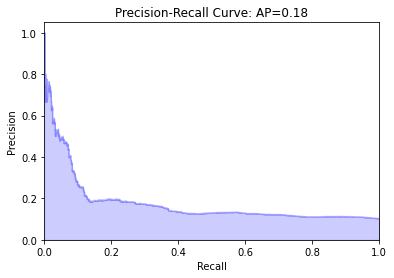

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



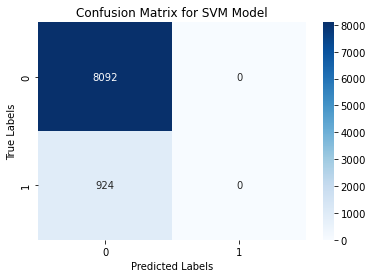

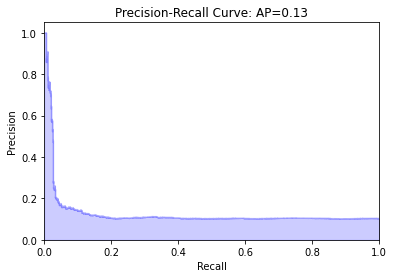

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



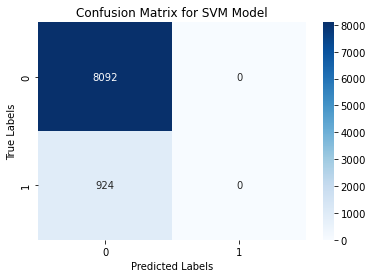

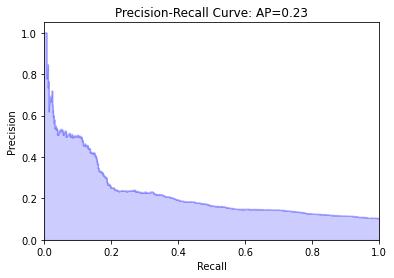

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      8092
           1       0.00      0.00      0.00       924

    accuracy                           0.90      9016
   macro avg       0.45      0.50      0.47      9016
weighted avg       0.81      0.90      0.85      9016



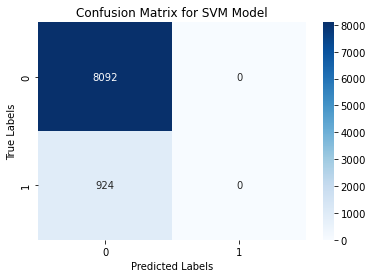

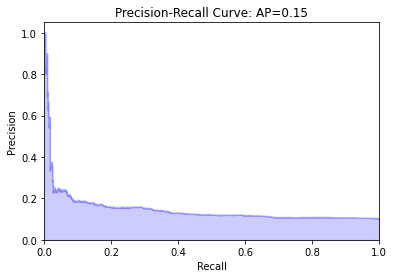

Mean accuracy: 0.8975155279503106
Standard deviation: 1.1102230246251565e-16


In [28]:
from sklearn.svm import SVC

X = normalized_df.drop(columns=['Goal'])
y = normalized_df['Goal']

# Create a stratified k-fold cross-validator with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the cross-validation scores
scores = []

# Initialize a list to store the predicted probabilities
y_prob = []

# Train and evaluate an SVM model for each fold
for train_idx, test_idx in skf.split(X, y):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train an SVM model with a linear kernel
    clf = SVC(kernel='linear', gamma=0.1, C=1, probability=True)
    clf.fit(X_train, y_train)

    # Make predictions on the testing set for this fold
    y_pred = clf.predict(X_test)
    y_prob.append(clf.predict_proba(X_test))

    # Evaluate the model's performance for this fold
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

    # Get the classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create heatmap of confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVM Model')
    plt.show()

    # Get the precision-recall curve
    y_score = clf.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # Plot the precision-recall curve
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

# Calculate the mean and standard deviation of the cross-validation scores
mean_score = sum(scores) / len(scores)
std_score = np.std(scores)
print('Mean accuracy:', mean_score)
print('Standard deviation:', std_score)

# Calculate the mean predicted probabilities
y_prob_mean = np.mean(y_prob, axis=0)

## Neural Network 

In [50]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.regularizers import l2
import keras

In [53]:
# splitting test and train data
X = normalized_df.drop(columns=['Goal'])
y = normalized_df['Goal']


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [74]:
# Define a range of possible layer numbers
layer_numbers = range(1, 11)

# Define an empty list to store the cross-validation scores
cv_scores = []

# Train and evaluate models with different layer numbers
for num_layers in layer_numbers:
    # Define the model with the current number of layers
    model = MLPClassifier(hidden_layer_sizes=(num_layers,), random_state=42)
    
    # Perform cross-validation with 5 folds
    scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Record the mean score
    cv_scores.append(np.mean(scores))

# Choose the optimal number of layers
optimal_num_layers = layer_numbers[np.argmax(cv_scores)]

In [35]:
optimal_num_layers

7

We first find out the optimal hidden layers for the neural network. Turns out the optimal value is 7. Next, we run an initial neural network model, with loss function as binary_crossentropy, neurons 128 and learning rate as 0.01.

In [75]:
# Define the model with 7 hidden layers
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu',  kernel_regularizer=l2(0.01)))

for _ in range(6):
    model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_score = model.evaluate(X_test, y_test)

Epoch 1/100
902/902 [==============================] - 16s 8ms/step - loss: 0.3386 - accuracy: 0.8981 - precision: 0.5705 - recall: 0.0287 - val_loss: 0.3077 - val_accuracy: 0.8967 - val_precision: 0.5638 - val_recall: 0.1099
Epoch 2/100
902/902 [==============================] - 8s 9ms/step - loss: 0.2965 - accuracy: 0.8994 - precision: 0.5667 - recall: 0.0818 - val_loss: 0.3143 - val_accuracy: 0.8957 - val_precision: 0.7500 - val_recall: 0.0236
Epoch 3/100
902/902 [==============================] - 8s 9ms/step - loss: 0.2930 - accuracy: 0.9008 - precision: 0.6056 - recall: 0.0949 - val_loss: 0.2925 - val_accuracy: 0.8971 - val_precision: 0.5491 - val_recall: 0.1610
Epoch 4/100
902/902 [==============================] - 10s 11ms/step - loss: 0.2910 - accuracy: 0.9006 - precision: 0.5865 - recall: 0.1054 - val_loss: 0.2922 - val_accuracy: 0.8960 - val_precision: 0.5427 - val_recall: 0.1165
Epoch 5/100
902/902 [==============================] - 10s 11ms/step - loss: 0.2890 - accuracy: 0

902/902 [==============================] - 2s 2ms/step - loss: 0.2845 - accuracy: 0.9013 - precision: 0.6290 - recall: 0.0922 - val_loss: 0.2915 - val_accuracy: 0.8957 - val_precision: 0.5330 - val_recall: 0.1270
Epoch 74/100
902/902 [==============================] - 2s 2ms/step - loss: 0.2846 - accuracy: 0.9019 - precision: 0.6411 - recall: 0.0990 - val_loss: 0.2895 - val_accuracy: 0.8981 - val_precision: 0.6706 - val_recall: 0.0746
Epoch 75/100
902/902 [==============================] - 2s 2ms/step - loss: 0.2847 - accuracy: 0.9014 - precision: 0.6340 - recall: 0.0919 - val_loss: 0.2875 - val_accuracy: 0.8964 - val_precision: 0.5752 - val_recall: 0.0851
Epoch 76/100
902/902 [==============================] - 2s 3ms/step - loss: 0.2841 - accuracy: 0.9015 - precision: 0.6434 - recall: 0.0902 - val_loss: 0.2939 - val_accuracy: 0.8935 - val_precision: 0.4925 - val_recall: 0.1728
Epoch 77/100
902/902 [==============================] - 2s 2ms/step - loss: 0.2843 - accuracy: 0.9008 - preci

In [76]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Generate a classification report
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

141/141 [==============================] - 2s 980us/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4057
           1       0.68      0.10      0.18       451

    accuracy                           0.91      4508
   macro avg       0.79      0.55      0.56      4508
weighted avg       0.89      0.91      0.87      4508



141/141 [==============================] - 0s 1ms/step


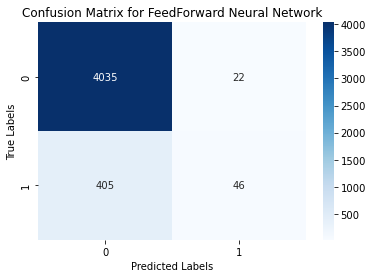

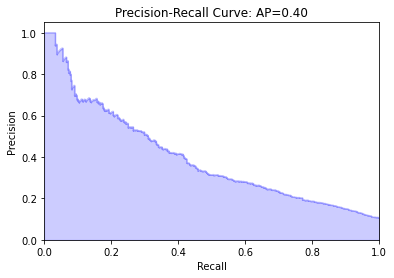

In [77]:
# Get the precision-recall curve
y_score12 = model.predict(X_test)
average_precision12 = average_precision_score(y_test, y_score12)
precision12, recall12, _ = precision_recall_curve(y_test, y_score12)

# Generate confusion matrix
cm12 = confusion_matrix(y_test, y_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm12, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for FeedForward Neural Network')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall12, precision12, color='b', alpha=0.2, where='post')
plt.fill_between(recall12, precision12, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision12))
plt.show()

141/141 [==============================] - 0s 1ms/step


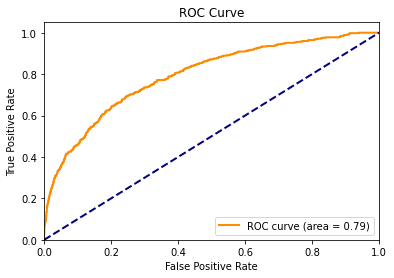

In [81]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_score = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


The accuracy improved massively to 91%. But, if we take a closer look the recall for the positive class is at 12%, which means that the model only correctly identified 12% of the goals. 

### Parameter Tuning Neural Network

In [51]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Define the model architecture as a function
def create_model(neurons=128, layers=7, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    for _ in range(layers-1):
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the Keras model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to search
param_grid = {
    'neurons': [64, 128, 256],
    'layers': [5, 6, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'sigmoid', 'tanh']
}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\oishi\AppData\Local\Temp\ipykernel_32620\747397408.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.900150 using {'activation': 'relu', 'layers': 7, 'learning_rate': 0.001, 'neurons': 128}


We get the best parameters for the neural networks. Now let's try different loss functions to see if we can improve the performance. Since this is an imbalanced dataset, we use a weighted binary cross entropy. This loss functopm assigns higher weights to the minority class and lower weights to the majority class. This way, the loss function penalizes the model more for misclassifying samples from the minority class and encourages it to focus on correctly classifying both classes.

#### Weighted Binary Crossentropy

In [195]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(pos_weight):
    def loss(y_true, y_pred):
        # Convert y_true to float32
        y_true = K.cast(y_true, dtype='float32')
        
        # Clip to prevent NaNs and Inf
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate the binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)
        
        # Apply the class weights
        weight_vector = y_true * pos_weight + (1 - y_true)
        weighted_bce = weight_vector * bce
        
        # Calculate the mean over all samples
        return K.mean(weighted_bce)
    
    return loss

# Define the model with 7 hidden layers
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu',  kernel_regularizer=l2(0.01)))

for _ in range(6):
    model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss=weighted_binary_crossentropy(pos_weight=2.0), optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_score = model.evaluate(X_test, y_test)

Epoch 1/100
1127/1127 [==============================] - 5s 3ms/step - loss: 0.5115 - accuracy: 0.8941 - precision_7: 0.4573 - recall_7: 0.1380 - val_loss: 0.4863 - val_accuracy: 0.8447 - val_precision_7: 0.3047 - val_recall_7: 0.4472
Epoch 2/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4641 - accuracy: 0.8908 - precision_7: 0.4356 - recall_7: 0.1933 - val_loss: 0.4451 - val_accuracy: 0.8995 - val_precision_7: 0.4762 - val_recall_7: 0.1798
Epoch 3/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4601 - accuracy: 0.8928 - precision_7: 0.4572 - recall_7: 0.2038 - val_loss: 0.4546 - val_accuracy: 0.9042 - val_precision_7: 0.5546 - val_recall_7: 0.1483
Epoch 4/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4569 - accuracy: 0.8939 - precision_7: 0.4642 - recall_7: 0.1794 - val_loss: 0.4491 - val_accuracy: 0.8891 - val_precision_7: 0.4143 - val_recall_7: 0.2989
Epoch 5/100
1127/1127 [==============================] - 4s 

Epoch 36/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4482 - accuracy: 0.8945 - precision_7: 0.4735 - recall_7: 0.1971 - val_loss: 0.4428 - val_accuracy: 0.8900 - val_precision_7: 0.4164 - val_recall_7: 0.2854
Epoch 37/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4495 - accuracy: 0.8953 - precision_7: 0.4830 - recall_7: 0.2027 - val_loss: 0.4453 - val_accuracy: 0.8929 - val_precision_7: 0.4269 - val_recall_7: 0.2494
Epoch 38/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4490 - accuracy: 0.8952 - precision_7: 0.4809 - recall_7: 0.1928 - val_loss: 0.4346 - val_accuracy: 0.8988 - val_precision_7: 0.4734 - val_recall_7: 0.2202
Epoch 39/100
1127/1127 [==============================] - 4s 3ms/step - loss: 0.4496 - accuracy: 0.8945 - precision_7: 0.4724 - recall_7: 0.1861 - val_loss: 0.4423 - val_accuracy: 0.8977 - val_precision_7: 0.4640 - val_recall_7: 0.2315
Epoch 40/100
1127/1127 [==============================] 

Epoch 71/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4481 - accuracy: 0.8944 - precision_7: 0.4737 - recall_7: 0.2003 - val_loss: 0.4641 - val_accuracy: 0.8680 - val_precision_7: 0.3424 - val_recall_7: 0.3663
Epoch 72/100
1127/1127 [==============================] - 4s 3ms/step - loss: 0.4484 - accuracy: 0.8944 - precision_7: 0.4729 - recall_7: 0.1941 - val_loss: 0.4349 - val_accuracy: 0.9013 - val_precision_7: 0.5000 - val_recall_7: 0.1865
Epoch 73/100
1127/1127 [==============================] - 3s 3ms/step - loss: 0.4468 - accuracy: 0.8945 - precision_7: 0.4752 - recall_7: 0.2030 - val_loss: 0.4362 - val_accuracy: 0.8984 - val_precision_7: 0.4652 - val_recall_7: 0.1955
Epoch 74/100
1127/1127 [==============================] - 4s 3ms/step - loss: 0.4479 - accuracy: 0.8948 - precision_7: 0.4768 - recall_7: 0.1958 - val_loss: 0.4362 - val_accuracy: 0.8953 - val_precision_7: 0.4430 - val_recall_7: 0.2360
Epoch 75/100
1127/1127 [==============================] 

In [196]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Generate a classification report
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

141/141 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4057
           1       0.57      0.24      0.34       451

    accuracy                           0.91      4508
   macro avg       0.74      0.61      0.65      4508
weighted avg       0.89      0.91      0.89      4508



141/141 [==============================] - 0s 1ms/step


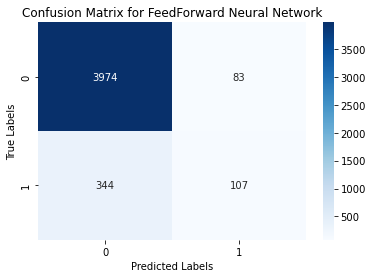

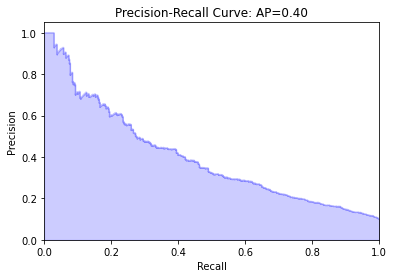

In [78]:
# Get the precision-recall curve
y_score12 = model.predict(X_test)
average_precision12 = average_precision_score(y_test, y_score12)
precision12, recall12, _ = precision_recall_curve(y_test, y_score12)

# Generate confusion matrix
cm12 = confusion_matrix(y_test, y_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm12, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for FeedForward Neural Network')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall12, precision12, color='b', alpha=0.2, where='post')
plt.fill_between(recall12, precision12, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision12))
plt.show()

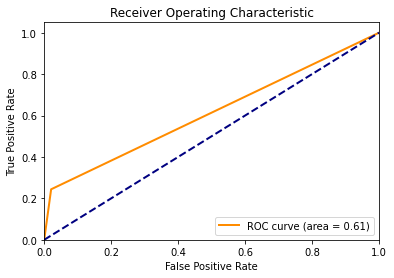

In [197]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


The accuracy for the above model is 91%, which is similar to the previous one. But, the recall went up from 12% to 24%  The weighted-average F1-score is 0.89, which takes into account the class imbalance and is a better measure of overall performance. Let's see if we can use SMOTE and do something about the class imbalance.

In [198]:
from imblearn.over_sampling import SMOTE


# Oversample the minority class with SMOTE
oversample = SMOTE()
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

# Define the model with 7 hidden layers
model = Sequential()
model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))

for _ in range(6):
    model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_score = model.evaluate(X_test, y_test)

Epoch 1/100
2022/2022 [==============================] - 7s 3ms/step - loss: 0.6059 - accuracy: 0.7050 - precision_8: 0.6962 - recall_8: 0.7275 - val_loss: 0.5242 - val_accuracy: 0.7331 - val_precision_8: 0.2225 - val_recall_8: 0.6831
Epoch 2/100
2022/2022 [==============================] - 5s 3ms/step - loss: 0.5714 - accuracy: 0.7118 - precision_8: 0.6972 - recall_8: 0.7487 - val_loss: 0.6148 - val_accuracy: 0.6127 - val_precision_8: 0.1749 - val_recall_8: 0.7865
Epoch 3/100
2022/2022 [==============================] - 6s 3ms/step - loss: 0.5675 - accuracy: 0.7135 - precision_8: 0.7045 - recall_8: 0.7354 - val_loss: 0.5655 - val_accuracy: 0.6783 - val_precision_8: 0.1989 - val_recall_8: 0.7461
Epoch 4/100
2022/2022 [==============================] - 5s 3ms/step - loss: 0.5648 - accuracy: 0.7124 - precision_8: 0.7053 - recall_8: 0.7299 - val_loss: 0.6012 - val_accuracy: 0.6808 - val_precision_8: 0.1988 - val_recall_8: 0.7371
Epoch 5/100
2022/2022 [==============================] - 6s 

Epoch 36/100
2022/2022 [==============================] - 6s 3ms/step - loss: 0.5543 - accuracy: 0.7199 - precision_8: 0.7055 - recall_8: 0.7549 - val_loss: 0.5239 - val_accuracy: 0.7112 - val_precision_8: 0.2099 - val_recall_8: 0.6966
Epoch 37/100
2022/2022 [==============================] - 6s 3ms/step - loss: 0.5545 - accuracy: 0.7203 - precision_8: 0.7039 - recall_8: 0.7604 - val_loss: 0.5640 - val_accuracy: 0.6644 - val_precision_8: 0.1942 - val_recall_8: 0.7618
Epoch 38/100
2022/2022 [==============================] - 5s 2ms/step - loss: 0.5538 - accuracy: 0.7202 - precision_8: 0.7019 - recall_8: 0.7655 - val_loss: 0.5689 - val_accuracy: 0.7072 - val_precision_8: 0.2116 - val_recall_8: 0.7213
Epoch 39/100
2022/2022 [==============================] - 5s 3ms/step - loss: 0.5540 - accuracy: 0.7192 - precision_8: 0.7032 - recall_8: 0.7583 - val_loss: 0.6510 - val_accuracy: 0.5992 - val_precision_8: 0.1707 - val_recall_8: 0.7933
Epoch 40/100
2022/2022 [==============================] 

Epoch 71/100
2022/2022 [==============================] - 5s 3ms/step - loss: 0.5500 - accuracy: 0.7224 - precision_8: 0.7081 - recall_8: 0.7569 - val_loss: 0.5391 - val_accuracy: 0.7043 - val_precision_8: 0.2102 - val_recall_8: 0.7236
Epoch 72/100
2022/2022 [==============================] - 6s 3ms/step - loss: 0.5506 - accuracy: 0.7231 - precision_8: 0.7097 - recall_8: 0.7550 - val_loss: 0.6194 - val_accuracy: 0.6429 - val_precision_8: 0.1863 - val_recall_8: 0.7775
Epoch 73/100
2022/2022 [==============================] - 6s 3ms/step - loss: 0.5500 - accuracy: 0.7227 - precision_8: 0.7074 - recall_8: 0.7596 - val_loss: 0.5702 - val_accuracy: 0.6854 - val_precision_8: 0.2024 - val_recall_8: 0.7438
Epoch 74/100
2022/2022 [==============================] - 6s 3ms/step - loss: 0.5500 - accuracy: 0.7230 - precision_8: 0.7080 - recall_8: 0.7590 - val_loss: 0.5439 - val_accuracy: 0.6963 - val_precision_8: 0.2072 - val_recall_8: 0.7348
Epoch 75/100
2022/2022 [==============================] 

In [144]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Generate a classification report
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

282/282 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      8120
           1       0.20      0.72      0.32       896

    accuracy                           0.69      9016
   macro avg       0.58      0.70      0.56      9016
weighted avg       0.88      0.69      0.75      9016



282/282 [==============================] - 1s 2ms/step


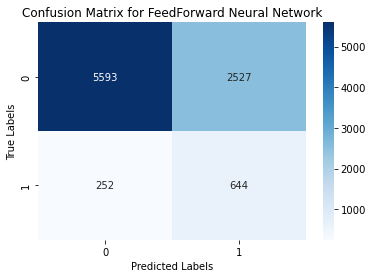

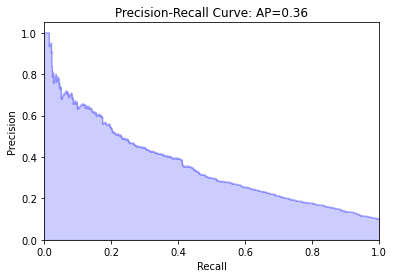

In [145]:
# Get the precision-recall curve
y_score12 = model.predict(X_test)
average_precision12 = average_precision_score(y_test, y_score12)
precision12, recall12, _ = precision_recall_curve(y_test, y_score12)

# Generate confusion matrix
cm12 = confusion_matrix(y_test, y_pred)

# Create heatmap of confusion matrix
sns.heatmap(cm12, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for FeedForward Neural Network')
plt.show()

# Plot the precision-recall curve
import matplotlib.pyplot as plt
plt.step(recall12, precision12, color='b', alpha=0.2, where='post')
plt.fill_between(recall12, precision12, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision12))
plt.show()

In this SMOTE model, we see an increase in the recall value of the positive class to 72%, but the overall accuracy went down. 

### Checking our Expected Goals Models

Let's put the models to use by predicting the likelihood of the shots being a goal. We will compare predictions on the models that we created till now: Logistic Regression with adjusted class weight, Random Forest, XGBoost and Feedforward Neural Network. Let's get started!

In [54]:
normalized_df.head()

,Goal,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,matchPeriod
0,0,0.0,1.0,0.0,0.0,0.0,0.428571,0.369688,0.093830,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.0,1.0,0.0,0.0,1.0,0.428571,0.740831,0.076209,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,1.0,0.142857,0.127429,0.329851,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0.0,0.0,1.0,0.0,0.0,0.224490,0.177574,0.182824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1.0,0.0,0.0,0.0,1.0,0.346939,0.629557,0.090254,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
# splitting test and train data
X = normalized_df.drop(columns=['Goal'])
y = normalized_df['Goal']


x_rf = normalized_df.drop(['Goal'], axis= 1)
x_logreg = x_rf.copy()
x_nn = x_rf.copy()
x_xgb = x_rf.copy()

In [57]:
x_logreg_train, x_logreg_test, y_train, y_test = train_test_split(x_logreg, y, test_size=0.2, random_state=42)
x_rf_train, x_rf_test, y_train, y_test = train_test_split(x_rf, y, test_size=0.2, random_state=42)
x_nn_train, x_nn_test, y_train, y_test = train_test_split(x_nn, y, test_size=0.2, random_state=42)
x_xgb_train, x_xgb_test, y_train, y_test = train_test_split(x_xgb, y, test_size=0.2, random_state=42)



# Oversample the minority class with SMOTE
oversample = SMOTE()
X_train_resampled_nn, y_train_resampled_nn = oversample.fit_resample(x_nn_train, y_train)


In [77]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)

random_forest_xg_model = RandomForestClassifier(random_state=42, 
                                                n_estimators=100, 
                                                criterion='gini', 
                                                max_depth=8,
                                                max_features=10, 
                                                min_samples_leaf=20, 
                                                min_samples_split=250
                                               )



xgb_model = XGBClassifier(random_state=42,
                                       subsample = 0.5,
                                       scale_pos_weight =  1,
                                       n_estimators = 100,
                                       max_depth = 5,
                                       learning_rate = 0.1,
                                       colsample_bytree= 1)

def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    for _ in range(6):
        model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return model

# Create a KerasClassifier object from the model function
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


C:\Users\oishi\AppData\Local\Temp\ipykernel_12776\424408780.py:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


In [78]:
rf_hat = cross_val_predict(random_forest_xg_model, x_rf, y, cv=5, method='predict_proba')[:,-1]
logreg_hat = cross_val_predict(logistic_regression, x_logreg,y, cv=5, method='predict_proba')[:,-1]
xgb_hat = cross_val_predict(xgb_model, x_xgb,y, cv=5, method='predict_proba')[:,-1]

In [79]:
rf_preds=pd.DataFrame(rf_hat, index =x_logreg.index, columns=['RF XG'])
logreg_preds = pd.DataFrame(logreg_hat, index = x_rf.index, columns=['Logistic XG'])
xgb_preds = pd.DataFrame(xgb_hat, index = x_xgb.index, columns=['XGBoost XG'])


In [61]:
nn_hat = cross_val_predict(model, x_nn, y, cv=5, method='predict_proba')[:, 1]

282/282 [==============================] - 0s 1ms/step


In [86]:
nn_preds = pd.DataFrame(nn_hat, index=x_nn.index, columns=['Neural Network XG'])

combined=pd.concat([rf_preds, logreg_preds, xgb_preds, nn_preds], axis=1)

In [87]:
shots_model2 = pd.read_csv("C:/Users/oishi/Downloads/Soccermetrics/shots_matrix.csv")
# remove outliers
shots_model2 = shots_model2[~outliers]

In [88]:
final_df=pd.merge(combined, shots_model2[['firstName', 'lastName', 'label', 'venue', 'date', 'eventSec', 
                                         'Goal', 'Distance', 'Angle', 'X', 'Y', 'C',
                                        'prev_cross', 'prev_touch', 'prev_pass', 'prev_smart_pass', 
                                        'free_kick', 'prev_duel', 'header', 'counter_attack', 'strong_foot', 'rebound']], left_index=True, 
                                         right_index=True,how='left')


In [89]:
final_df

,RF XG,Logistic XG,XGBoost XG,Neural Network XG,firstName,lastName,label,venue,date,eventSec,...,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,header,counter_attack,strong_foot,rebound
0,0.079810,0.055339,0.104287,0.059737,Blaise,Matuidi,"France - Romania, 2 - 1",Stade de France,"June 10, 2016 at 9:00:00 PM GMT+2",31.226217,...,0,0,1,0,0,0,0,0,0,0
1,0.014399,0.010071,0.010960,0.022257,Mihai Doru,Pintilii,"France - Romania, 2 - 1",Stade de France,"June 10, 2016 at 9:00:00 PM GMT+2",143.119551,...,0,0,1,0,0,0,0,0,1,0
2,0.361431,0.340678,0.377309,0.396666,Bogdan Sorin,Stancu,"France - Romania, 2 - 1",Stade de France,"June 10, 2016 at 9:00:00 PM GMT+2",219.576026,...,0,0,0,0,0,1,0,0,1,0
3,0.112710,0.085004,0.096621,0.081535,Florin,Andone,"France - Romania, 2 - 1",Stade de France,"June 10, 2016 at 9:00:00 PM GMT+2",247.532561,...,0,0,0,0,0,1,1,0,0,0
4,0.017228,0.020799,0.014182,0.026885,Antoine,Griezmann,"France - Romania, 2 - 1",Stade de France,"June 10, 2016 at 9:00:00 PM GMT+2",557.319065,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45279,0.458708,0.506520,0.436343,0.453565,Diego Sebasti\u00e1n,Laxalt Su\u00e1rez,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",1152.032980,...,0,1,0,0,0,0,0,0,1,0
45280,0.226432,0.273170,0.264993,0.188032,Giuseppe,Rossi,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",1251.730517,...,0,0,0,1,0,0,0,0,1,0
45281,0.239266,0.230403,0.283948,0.173086,Goran,Pandev,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",2065.034482,...,0,0,0,0,0,1,0,0,1,0
45282,0.028230,0.030449,0.028023,0.022229,Stephane,Omeonga,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",2367.252041,...,0,0,1,0,0,0,0,0,1,0


Let's analyze one goal to interpret the Expected Goals of different models. 

In [90]:
final_df.loc[(final_df['lastName'] == 'Benzema') & (final_df['Goal'] == 1)]

,RF XG,Logistic XG,XGBoost XG,Neural Network XG,firstName,lastName,label,venue,date,eventSec,...,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,header,counter_attack,strong_foot,rebound
29236,0.067758,0.085759,0.040250,0.048491,Karim,Benzema,"Getafe - Real Madrid, 1 - 2",Coliseum Alfonso P\u00e9rez,"October 14, 2017 at 4:15:00 PM GMT+2",2337.186291,...,0,0,0,0,0,1,0,1,1,0
30485,0.434929,0.530831,0.417738,0.581467,Karim,Benzema,"Real Madrid - M\u00e1laga, 3 - 2",Estadio Santiago Bernab\u00e9u,"November 25, 2017 at 4:15:00 PM GMT+1",535.343970,...,0,0,0,0,0,0,1,0,0,1
32808,0.166916,0.174622,0.141280,0.112903,Karim,Benzema,"Real Betis - Real Madrid, 3 - 5",Estadio Benito Villamar\u00edn,"February 18, 2018 at 8:45:00 PM GMT+1",2762.808082,...,0,0,1,0,0,0,0,0,1,0


Let's have a look at this goal from Benzema, my favourite footballer at the moment

![Alt Text](Benzema.gif)

### Karim Benzema vs Malaga

In [91]:
final_df.loc[30485]

RF XG                                             0.434929
Logistic XG                                       0.530831
XGBoost XG                                        0.417738
Neural Network XG                                 0.581467
firstName                                            Karim
lastName                                           Benzema
label                     Real Madrid - M\u00e1laga, 3 - 2
venue                       Estadio Santiago Bernab\u00e9u
date                 November 25, 2017 at 4:15:00 PM GMT+1
eventSec                                         535.34397
Goal                                                     1
Distance                                          4.254692
Angle                                            81.295799
X                                                        4
Y                                                       49
C                                                      1.0
prev_cross                                              

In [67]:
final_df.loc[final_df['firstName'].str.contains('Cristiano Ronaldo') & (final_df['Goal'] == 1)].head(50)

,RF XG,Logistic XG,XGBoost XG,Neural Network XG,firstName,lastName,label,venue,date,eventSec,...,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,header,counter_attack,strong_foot,rebound
828,0.244927,0.720006,0.232865,0.275969,Cristiano Ronaldo,dos Santos Aveiro,"Hungary - Portugal, 3 - 3",Groupama Stadium,"June 22, 2016 at 6:00:00 PM GMT+2",245.378461,...,1,0,0,0,0,0,0,0,1,0
833,0.243282,0.750334,0.271267,0.297425,Cristiano Ronaldo,dos Santos Aveiro,"Hungary - Portugal, 3 - 3",Groupama Stadium,"June 22, 2016 at 6:00:00 PM GMT+2",992.217164,...,1,0,0,0,0,0,1,0,0,0
1208,0.105419,0.500960,0.090696,0.105023,Cristiano Ronaldo,dos Santos Aveiro,"Portugal - Wales, 2 - 0",Groupama Stadium,"July 6, 2016 at 9:00:00 PM GMT+2",280.101722,...,0,0,0,0,0,1,1,0,0,0
1422,0.078001,0.396581,0.053807,0.089321,Cristiano Ronaldo,dos Santos Aveiro,"Portugal - Spain, 3 - 3",Olimpiyskiy Stadion Fisht,"June 15, 2018 at 8:00:00 PM GMT+2",2620.470040,...,0,0,1,0,0,0,0,0,0,0
1429,0.071397,0.422708,0.086280,0.124441,Cristiano Ronaldo,dos Santos Aveiro,"Portugal - Spain, 3 - 3",Olimpiyskiy Stadion Fisht,"June 15, 2018 at 8:00:00 PM GMT+2",2522.777450,...,0,0,0,0,1,0,0,0,1,0
1453,0.172458,0.591102,0.180272,0.201108,Cristiano Ronaldo,dos Santos Aveiro,"Portugal - Morocco, 1 - 0",Olimpiyskiy stadion Luzhniki,"June 20, 2018 at 2:00:00 PM GMT+2",238.370833,...,0,0,0,0,0,0,1,0,0,0
29243,0.189106,0.661492,0.175953,0.118390,Cristiano Ronaldo,dos Santos Aveiro,"Getafe - Real Madrid, 1 - 2",Coliseum Alfonso P\u00e9rez,"October 14, 2017 at 4:15:00 PM GMT+2",2379.460637,...,0,0,0,0,0,0,0,0,1,0
30504,0.366662,0.897585,0.404046,0.579924,Cristiano Ronaldo,dos Santos Aveiro,"Real Madrid - M\u00e1laga, 3 - 2",Estadio Santiago Bernab\u00e9u,"November 25, 2017 at 4:15:00 PM GMT+1",1823.287712,...,0,0,0,0,0,0,0,0,0,0
30979,0.183920,0.613536,0.149510,0.069509,Cristiano Ronaldo,dos Santos Aveiro,"Real Madrid - Sevilla, 5 - 0",Estadio Santiago Bernab\u00e9u,"December 9, 2017 at 4:15:00 PM GMT+1",1331.988046,...,0,0,0,1,0,0,0,0,1,0
31906,0.623639,0.916557,0.647906,0.633843,Cristiano Ronaldo,dos Santos Aveiro,"Real Madrid - Deportivo La Coru\u00f1a, 7 - 1",Estadio Santiago Bernab\u00e9u,"January 21, 2018 at 4:15:00 PM GMT+1",1964.306371,...,1,0,0,0,0,0,0,0,0,0


In this gif, we can see that Benzema was shooting into almost an open goal after the ball came back as a rebound. Our Random Forest and Neural Network model predicted that on any given day, the likelihood of that shot ending up at the back of the net is 43% and 63% respectively. But the Logistic Regression overestimates that the likelihood by 92%

![Alt Text](Ronaldo.gif)

### Cristiano Ronaldo vs Real Sociedad

In [92]:
final_df.loc[32637]

RF XG                                             0.051305
Logistic XG                                       0.061011
XGBoost XG                                        0.057901
Neural Network XG                                  0.03562
firstName                                Cristiano Ronaldo
lastName                                 dos Santos Aveiro
label                   Real Madrid - Real Sociedad, 5 - 2
venue                       Estadio Santiago Bernab\u00e9u
date                 February 10, 2018 at 8:45:00 PM GMT+1
eventSec                                       2192.937774
Goal                                                     1
Distance                                         12.766993
Angle                                            29.472753
X                                                       11
Y                                                       58
C                                                      8.0
prev_cross                                              

In [93]:
RoaldoLaLiga = final_df.loc[final_df['firstName'].str.contains('Cristiano Ronaldo') & final_df['label'].str.contains('Real Madrid')]

In [94]:
totalXG = RoaldoLaLiga[['RF XG', 'Logistic XG', 'XGBoost XG', 'Neural Network XG']].sum()

print(totalXG)

RF XG                23.380603
Logistic XG          23.133843
XGBoost XG           23.242256
Neural Network XG    18.531937
dtype: float64


In [95]:
BenzemaLaLiga = final_df.loc[(final_df['lastName'] == 'Benzema') & final_df['label'].str.contains('Real Madrid')]

In [96]:
totalXG2 = BenzemaLaLiga[['RF XG', 'Logistic XG', 'XGBoost XG', 'Neural Network XG']].sum()

print(totalXG2)

RF XG                9.048208
Logistic XG          8.947584
XGBoost XG           8.625677
Neural Network XG    7.216811
dtype: float64


### Referrences : 

1. https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
2. https://www.nature.com/articles/s41597-019-0247-7
3. https://soccermatics.readthedocs.io/en/latest/
4. https://github.com/eddwebster/football_analytics
5. https://github.com/devinpleuler/analytics-handbook
6. https://github.com/iandragulet/xG_Model_Workflow
7. https://github.com/KubaMichalczyk/Expected-Goals-Model
8. https://github.com/andrewsimplebet/expected_goals_deep_dive
9. https://github.com/Dato-Futbol/xg-model
10.https://github.com/andrewRowlinson/expected-goals-thesis
11.http://www.statsandsnakeoil.com/2021/06/09/does-xg-really-tell-all/
12.https://pena.lt/y/2014/02/12/expected-goals-for-all
13.https://mplsoccer.readthedocs.io/en/latest/index.html
14.https://www.youtube.com/watch?v=Xc6IG9-Dt18
15.https://www.datofutbol.cl/xg-model/
16.https://www.kaggle.com/gabrielmanfredi/expected-goals-player-analysis
17.https://differentgame.wordpress.com/2017/04/29/an-xg-model-for-everyone-in-20-minutes-ish/
18.https://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/
19.https://web.archive.org/web/20200301071559/http://petermckeever.com/2019/01/building-an-expected-goals-model-in-python/
20.https://www.statsperform.com/resource/introducing-expected-goals-on-target-xgot/
